import required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Use Seaborn's context settings to make fonts larger.
import seaborn as sns
sns.set_context('talk')

generate csv file for all policies for the static trace collecting information from the logs such as cluster_spec, policy_name, seed, total_jobs, cost, utilization, average_completion_time, total_completion_time

In [2]:
raw_log_path = "/home/piyush/rp/work/logs4/static/raw_logs/"
cluster_specs = os.listdir(raw_log_path)
output_file = "static_logs.csv"
append_to_file = False

if os.path.exists(output_file):
    append_to_file = True

with open(output_file, 'a') as output_file:
    #workaround, since can't store all simulation logs at the same time due to space issues
    if append_to_file:
        output_file.seek(0,2)
    else:
        output_file.write("cluster_spec,policy_name,seed,total_jobs,cost,utilization,average_completion_time,total_completion_time\n")

    for cluster_spec in cluster_specs:
        worker_type = [worker.split("=")[0] for worker in cluster_spec.split(".")]
        worker_count = [worker.split("=")[1] for worker in cluster_spec.split(".")]        

        policies = os.listdir(raw_log_path + cluster_spec + "/")
        for policy in policies:            

            seeds = os.listdir(raw_log_path + cluster_spec + "/" + policy)
            for seed in seeds:
                
                for file in os.listdir(raw_log_path + cluster_spec + "/" + policy + "/" + seed):
                    num_jobs = file.split(".")[0].split("=")[1].strip()

                    output_file.write(cluster_spec)
                    output_file.write(",")
                    output_file.write(policy)
                    output_file.write(",")
                    output_file.write(seed.split("=")[1])
                    output_file.write(",")
                    output_file.write(num_jobs)
                    output_file.write(",")
                    
                    with open(raw_log_path + cluster_spec + "/" + policy + "/" + seed + "/" + file, 'r') as log_file:
                        lines = log_file.readlines()
                        index = len(lines)

                        #total cost
                        index = index - 1
                        cost = lines[index].strip()
                        output_file.write(cost.split(":")[1].split("$")[1].strip())
                        output_file.write(",")

                        #cluster utilization
                        index = index - 1
                        cluster_utilization = lines[index].strip()
                        output_file.write(cluster_utilization.split(":")[1].strip())
                        output_file.write(",")

                        #Average job completion time
                        index = index - 2
                        avg_job_completion_time = lines[index].strip()
                        output_file.write(avg_job_completion_time.split(":")[1].strip())
                        output_file.write(",")

                        #total duration for all jobs
                        index -= int(num_jobs)
                        total_job_completion_time = lines[index - 2].strip()
                        output_file.write(total_job_completion_time.split(":")[1].strip())
                        
                        output_file.write("\n")

create a pandas data frame for static trace data of shared_cloud_cost_fairness policy

In [3]:
csv_path = '/home/piyush/rp/work/analysis/evaluation/static_logs.csv'
df_static = pd.read_csv(csv_path)

how does utilization vary with total jobs for all policies for each seed

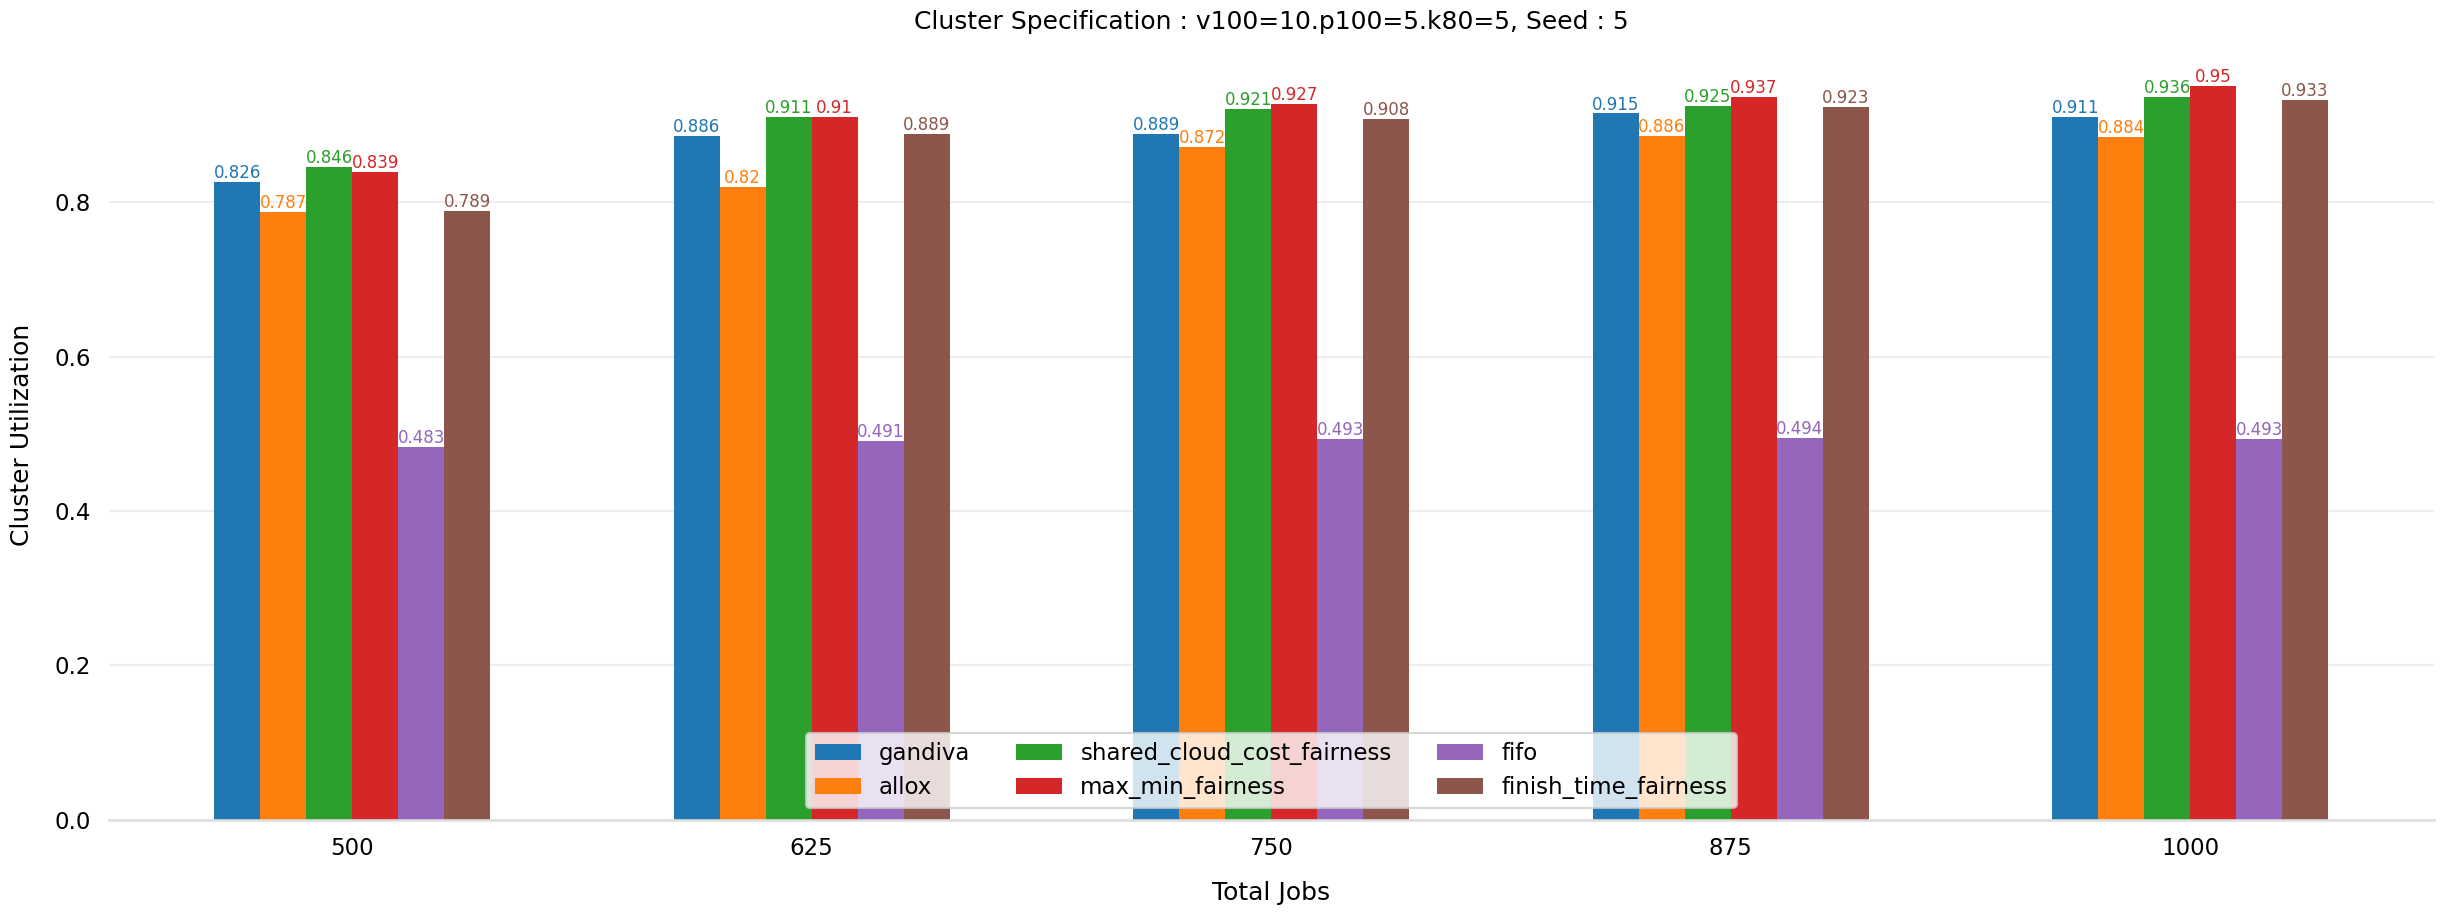

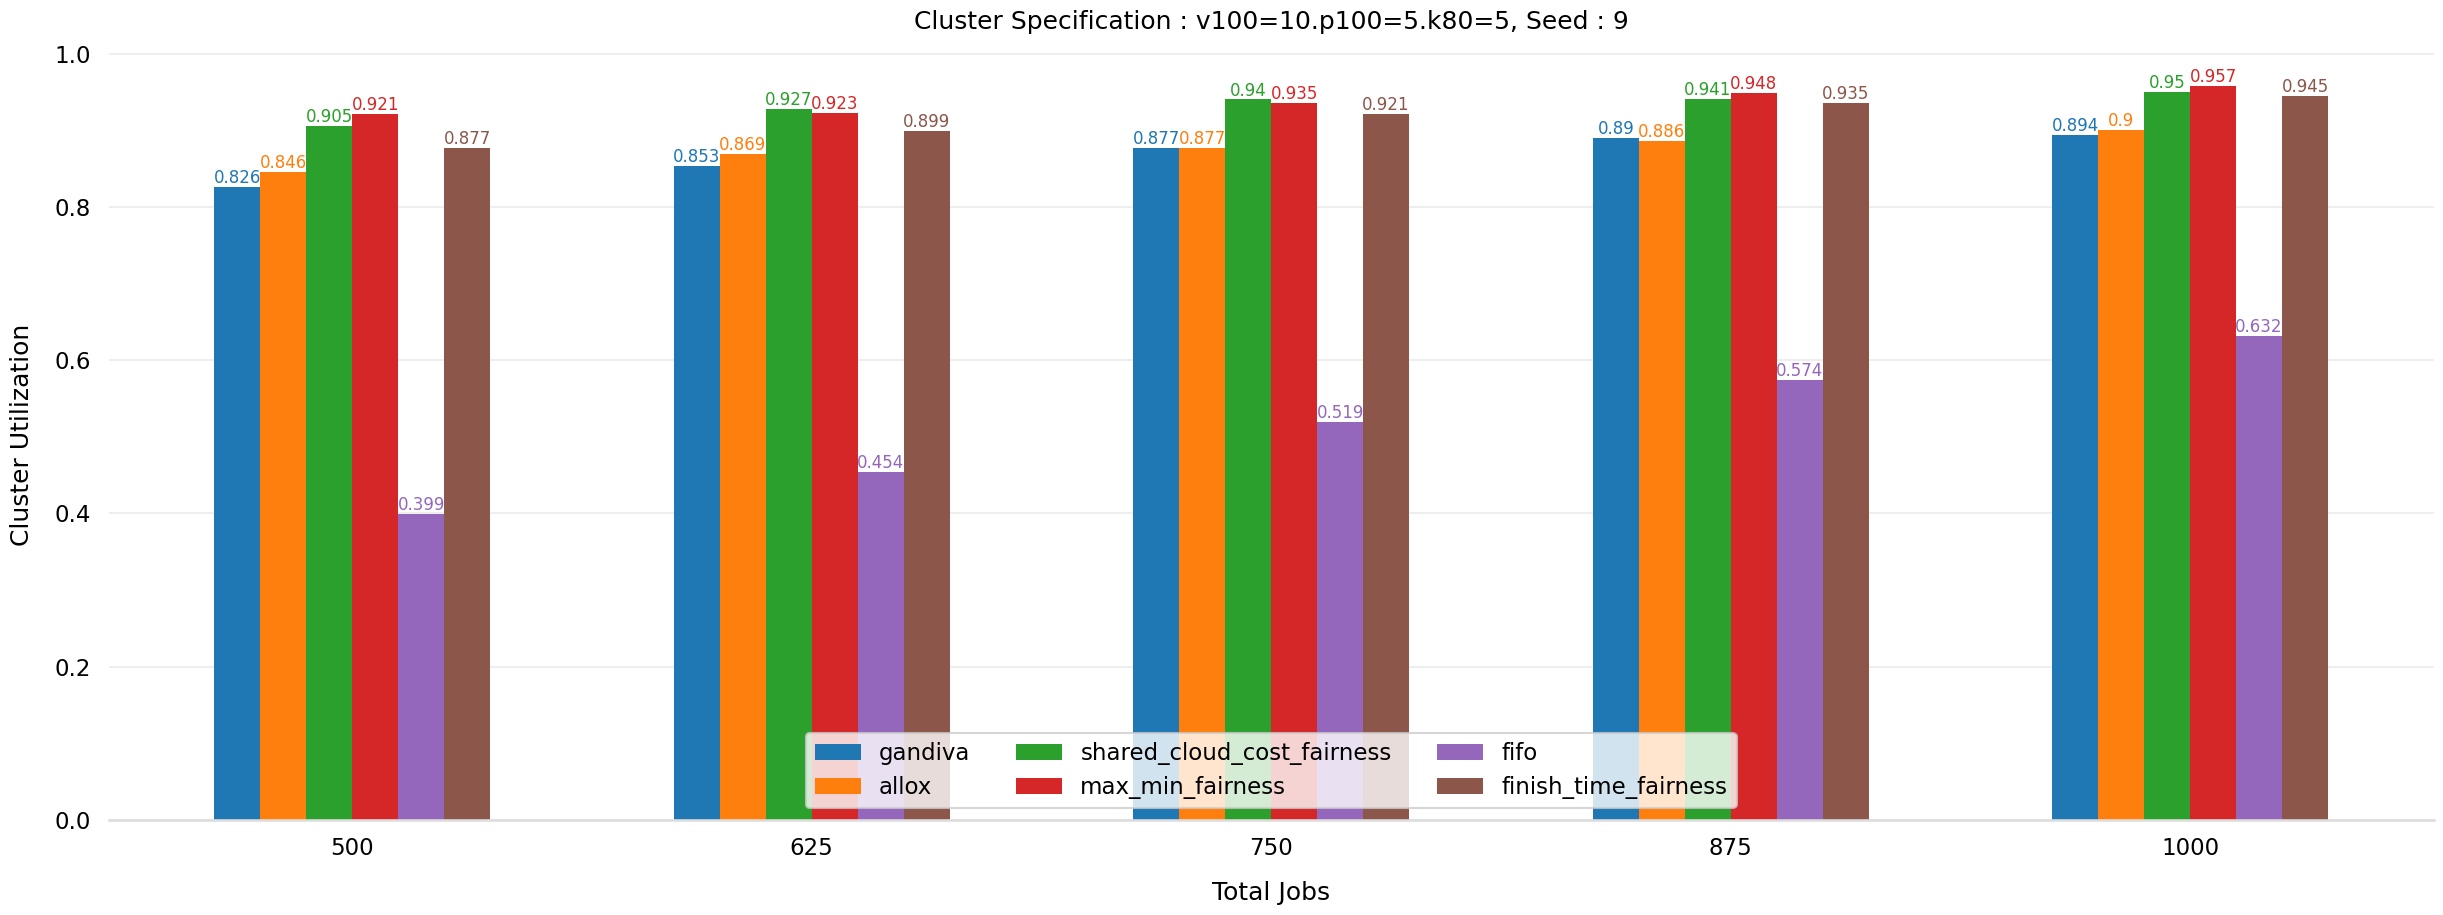

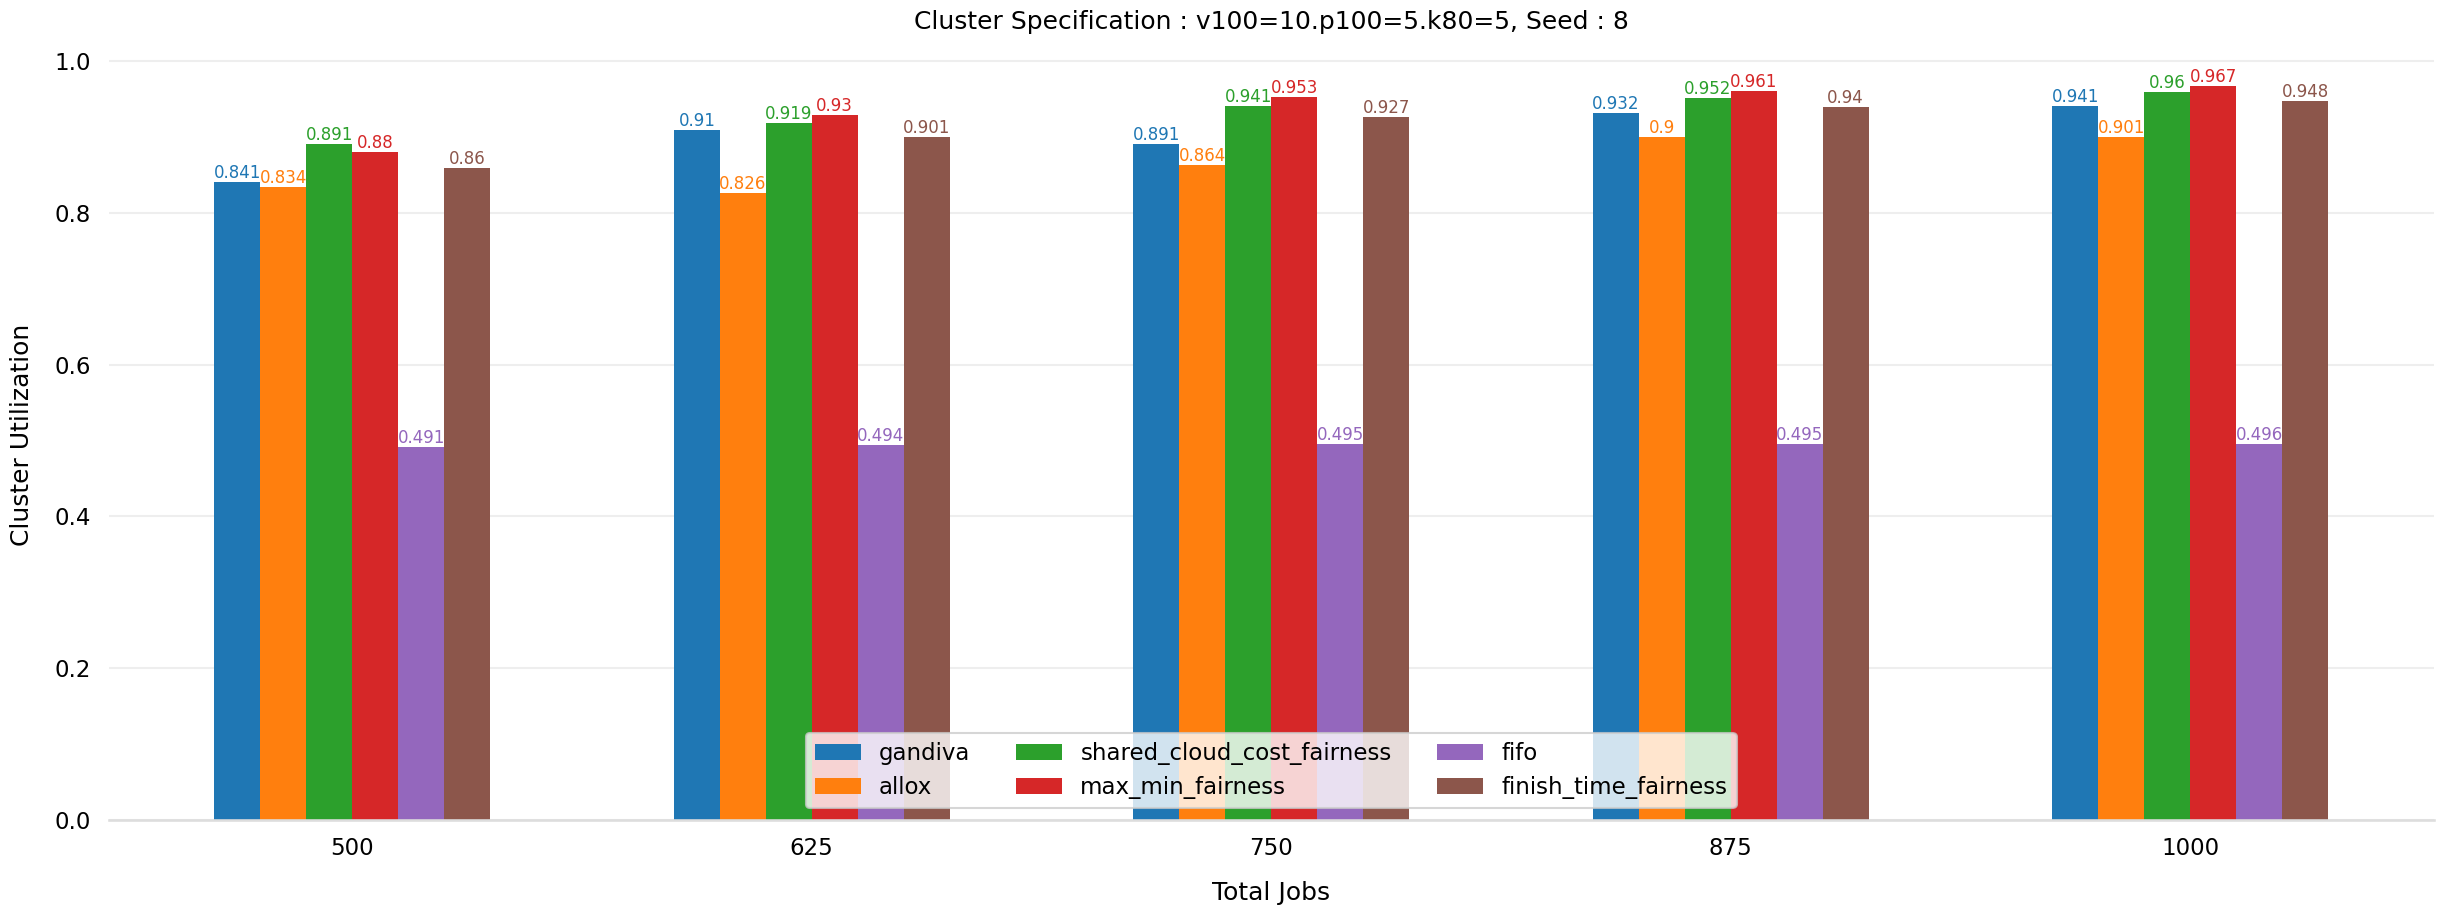

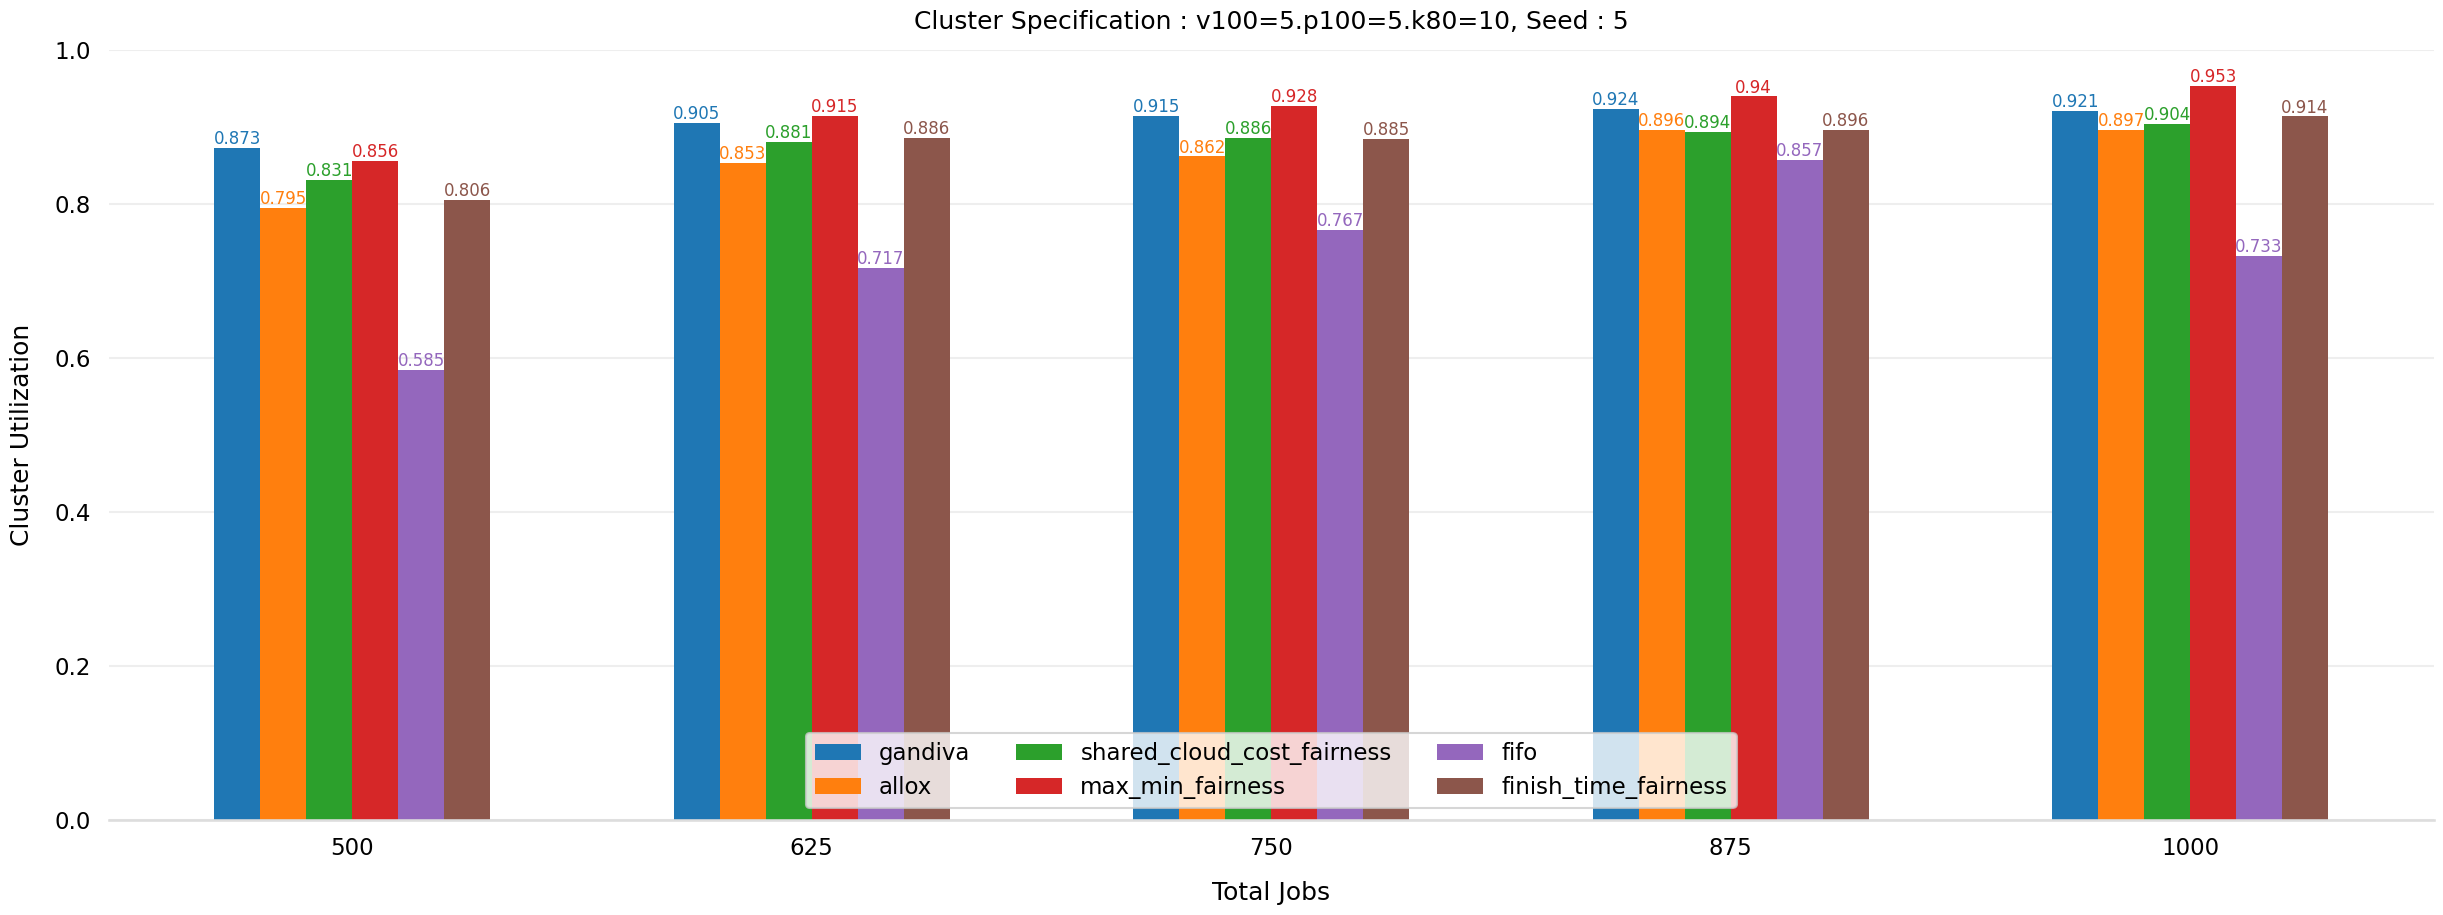

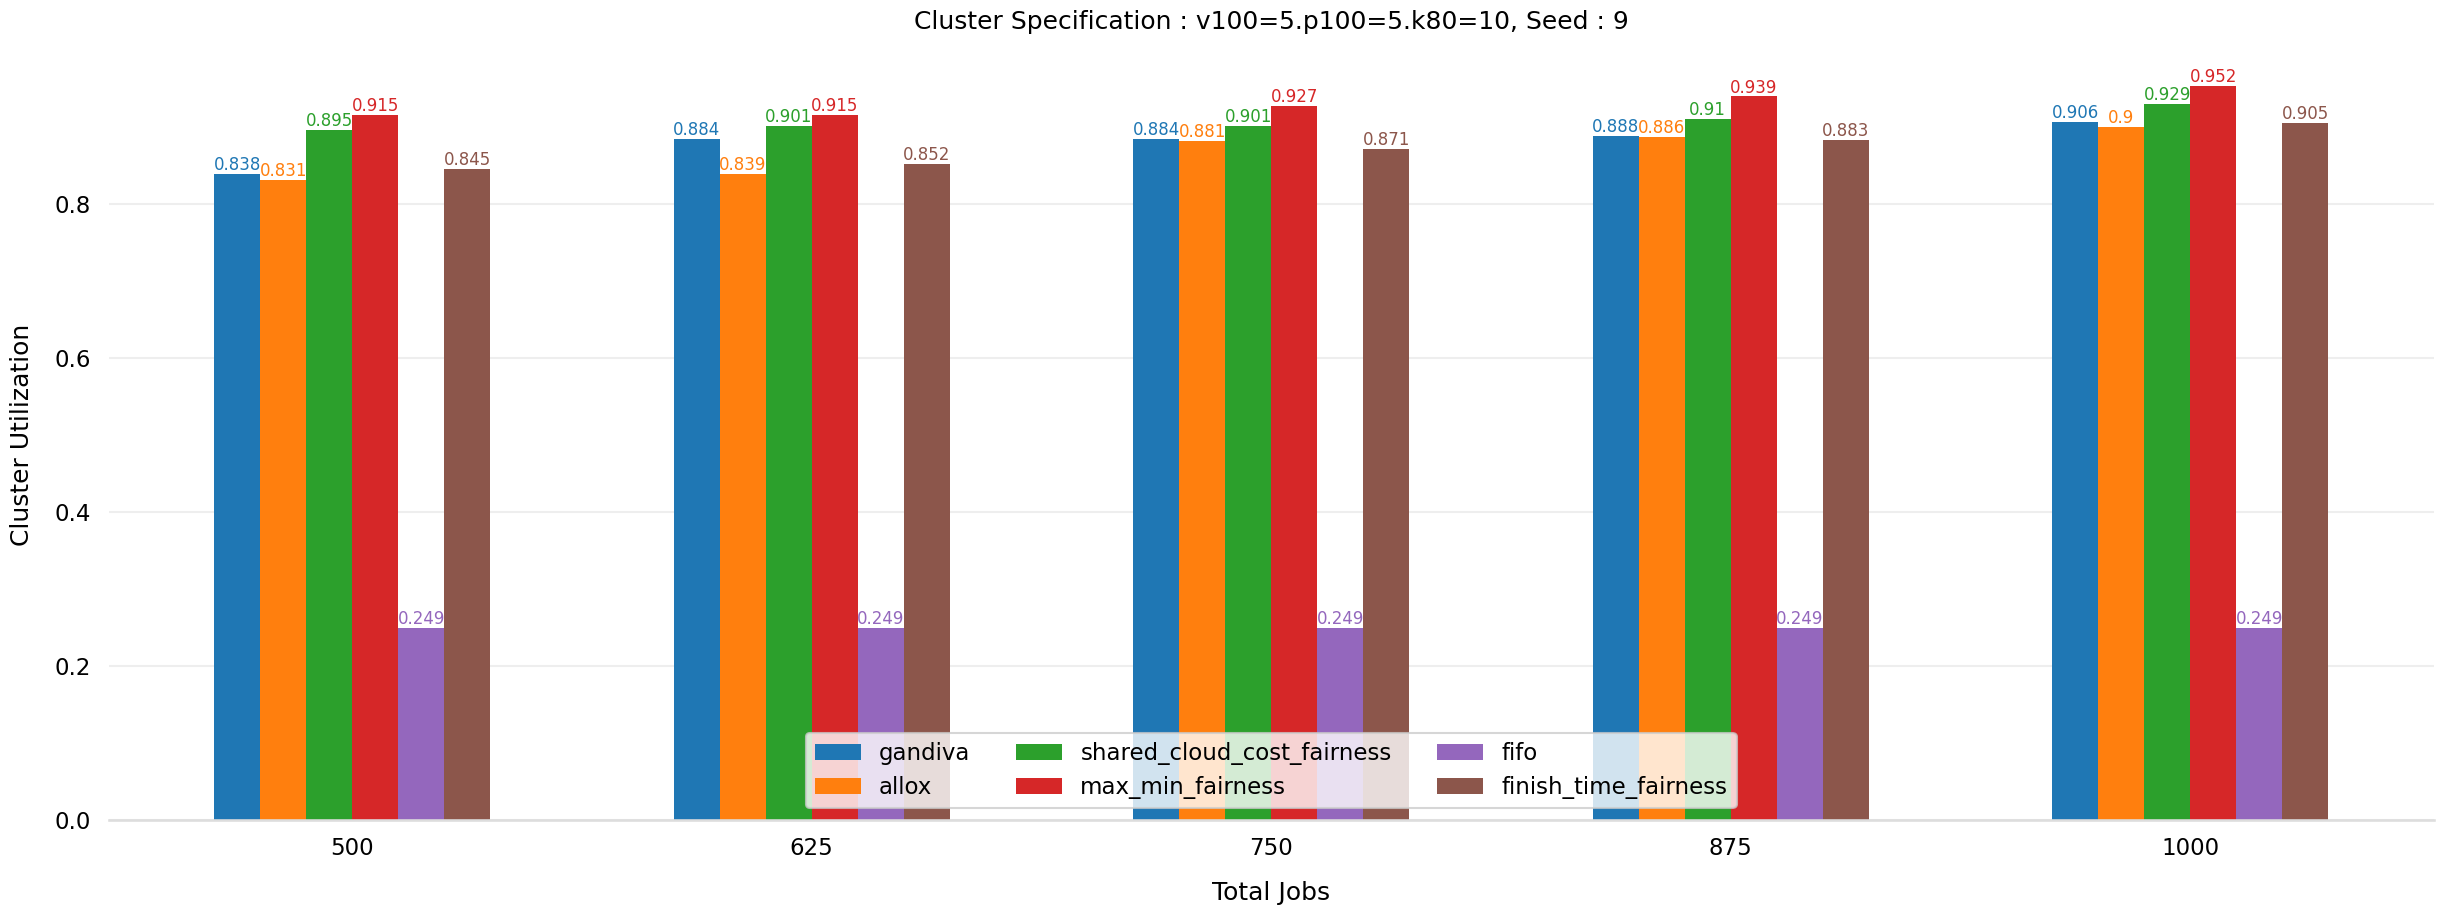

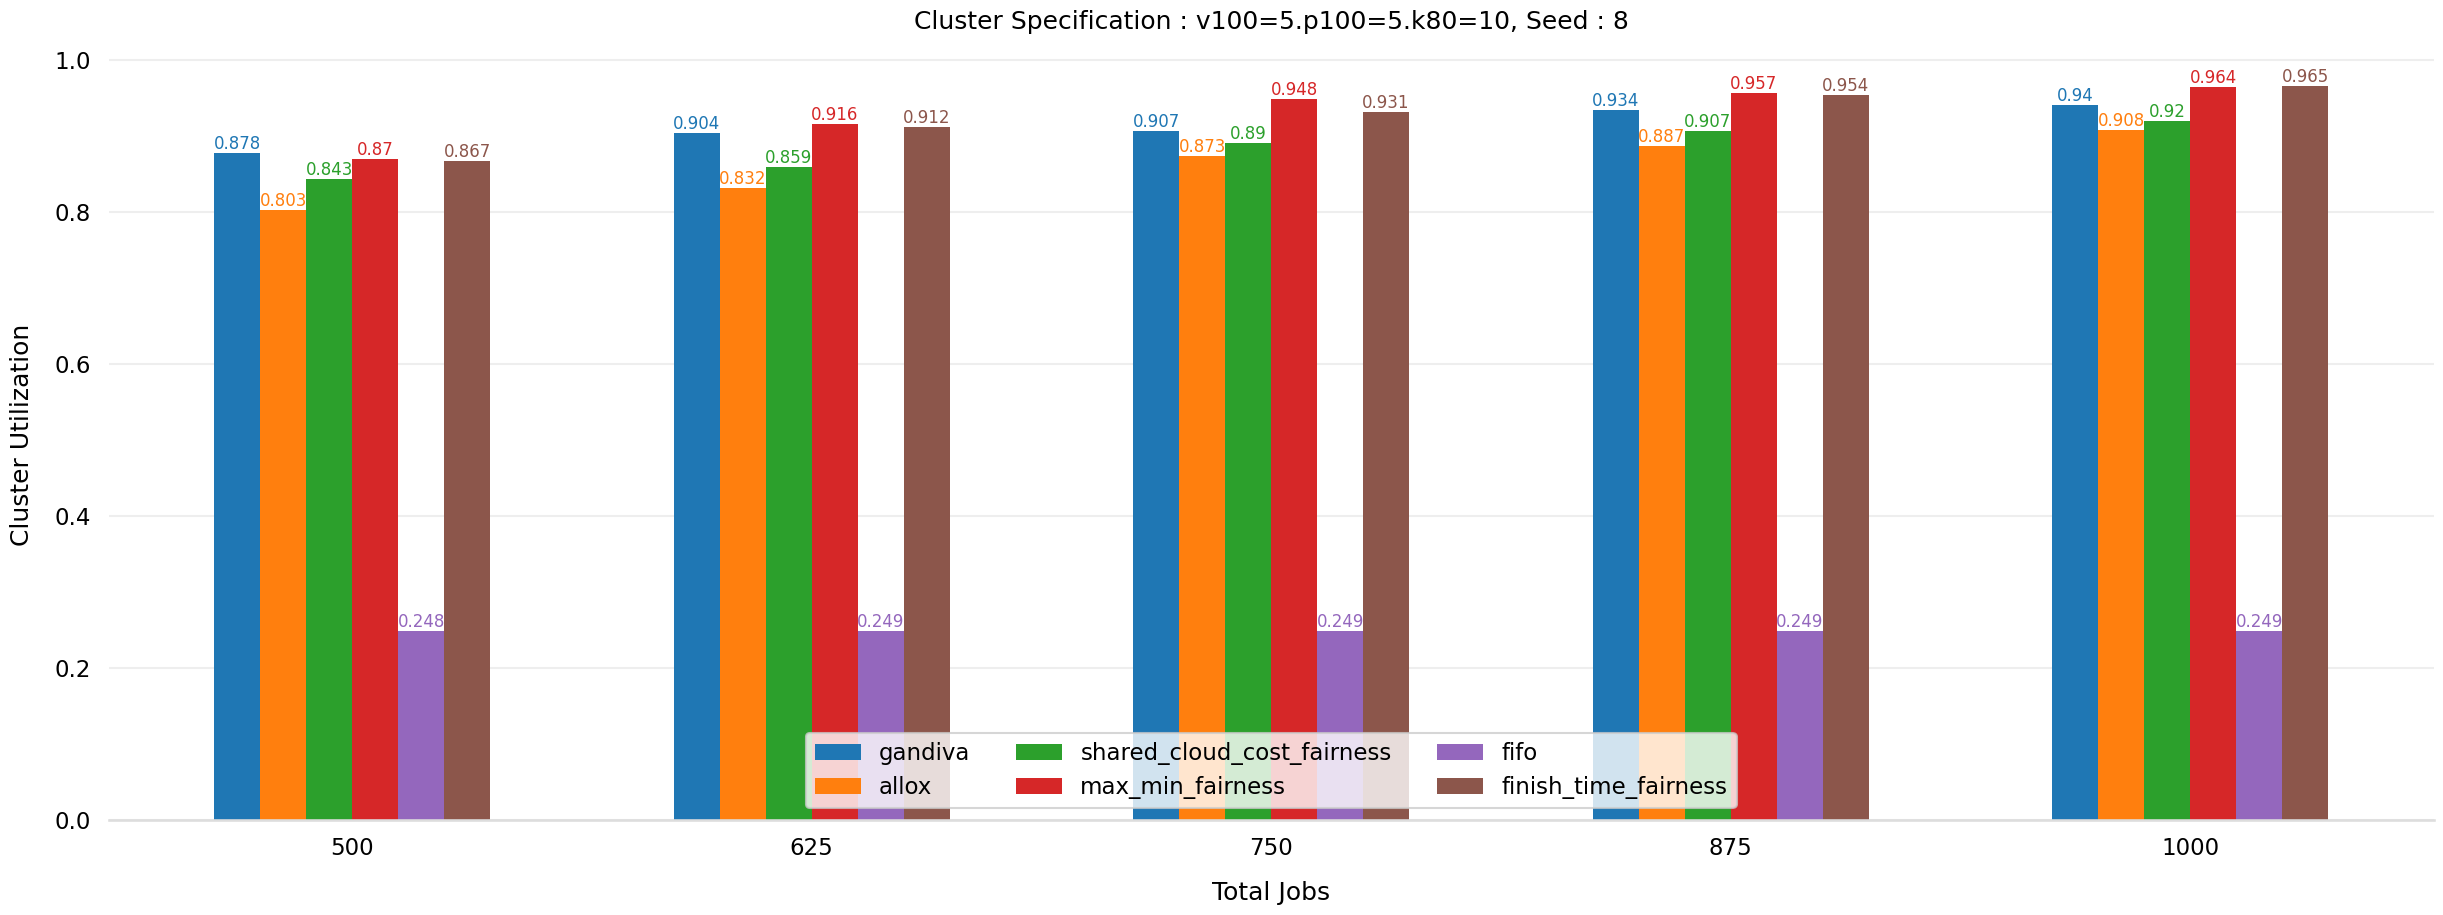

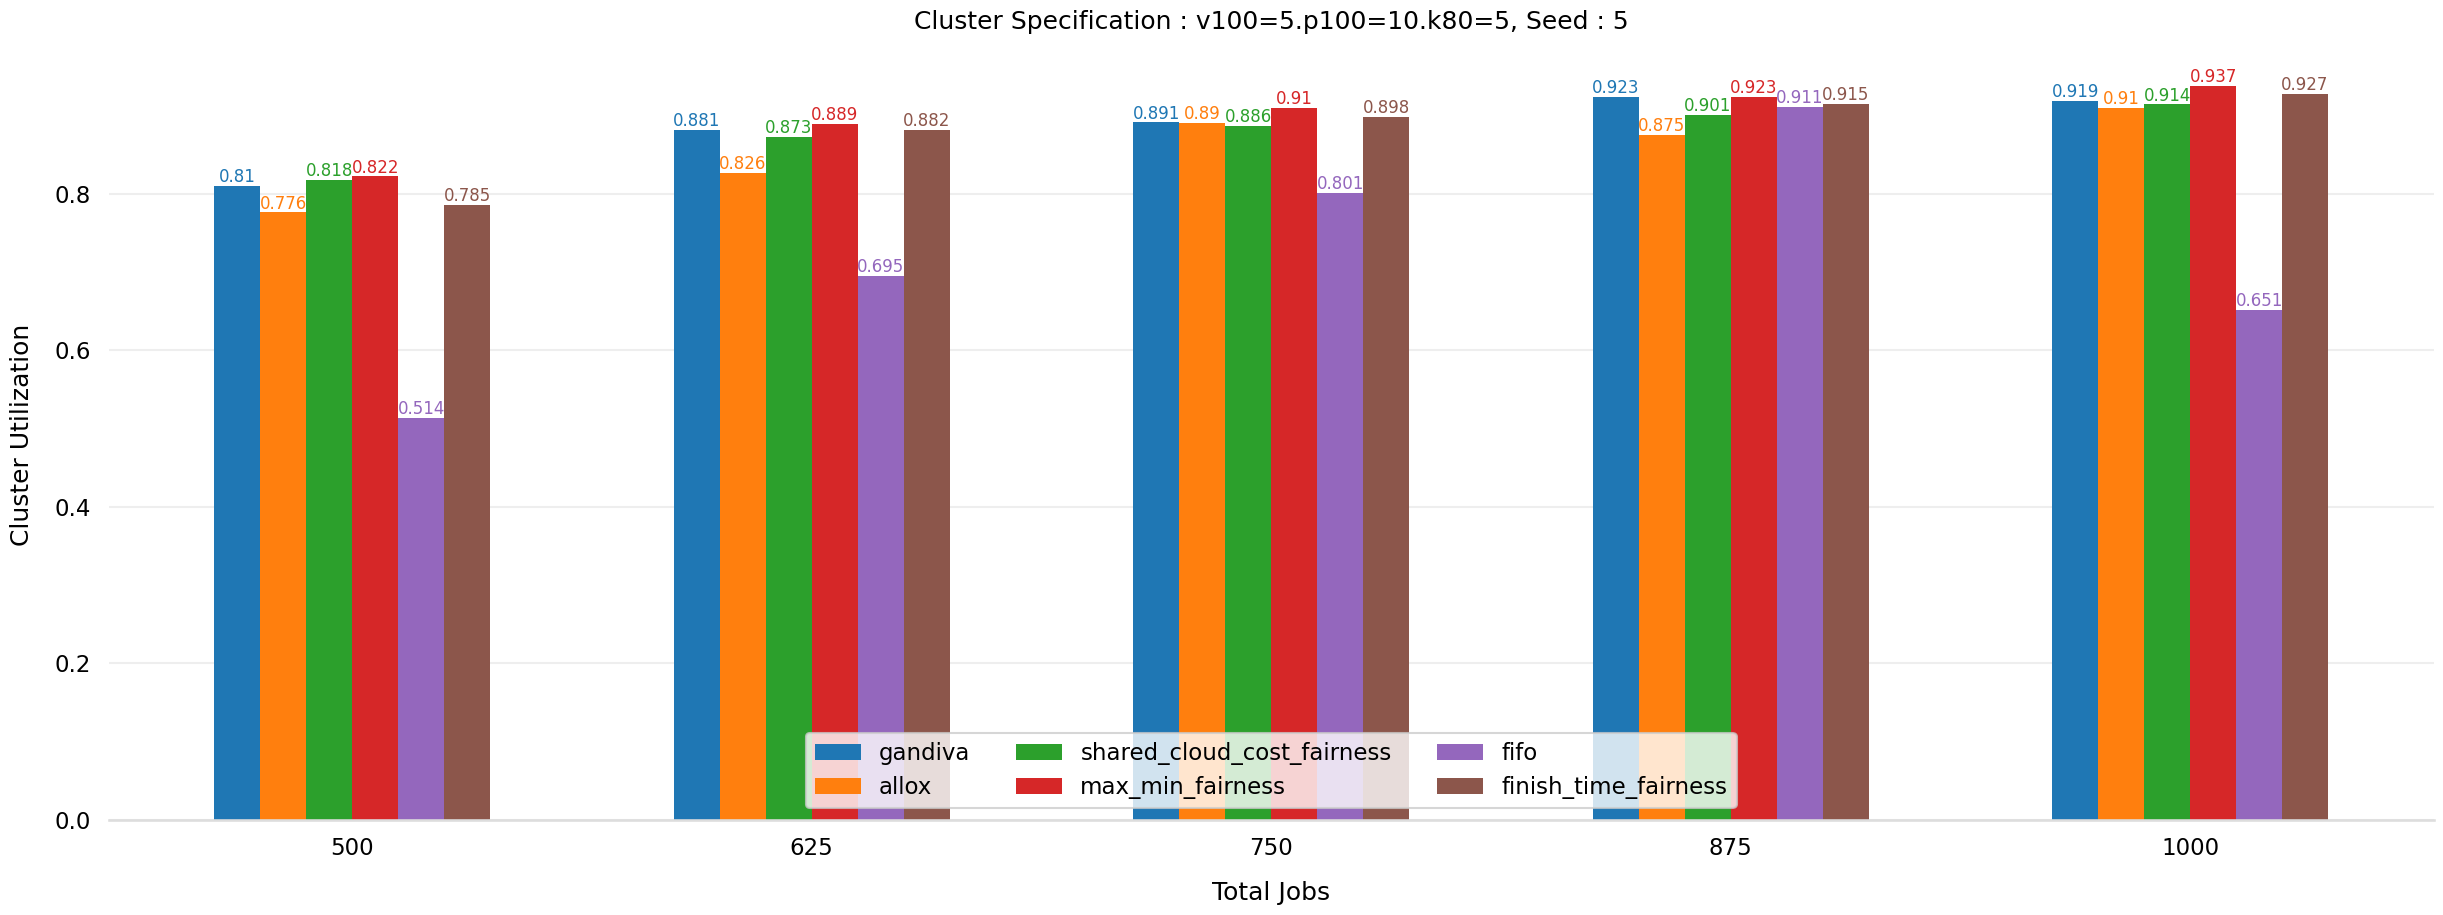

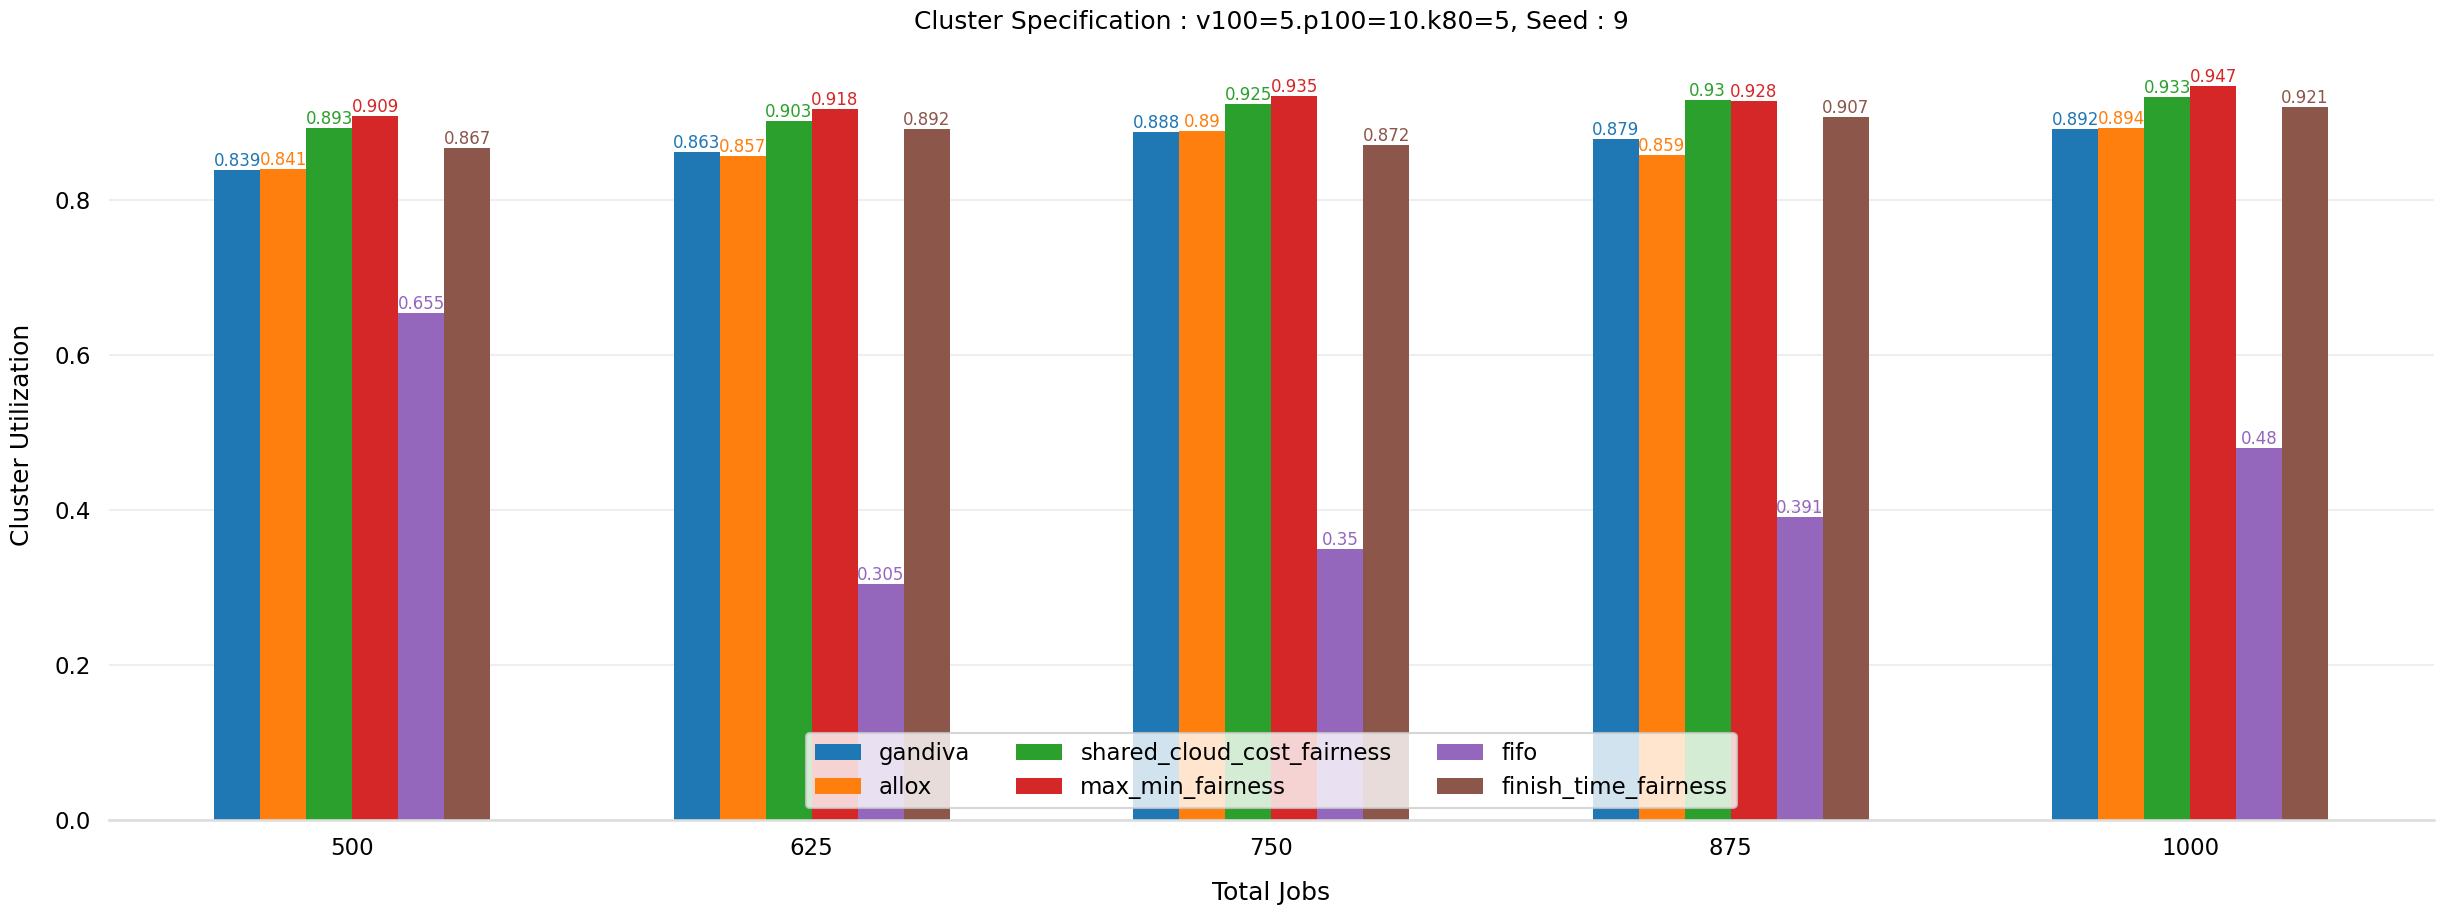

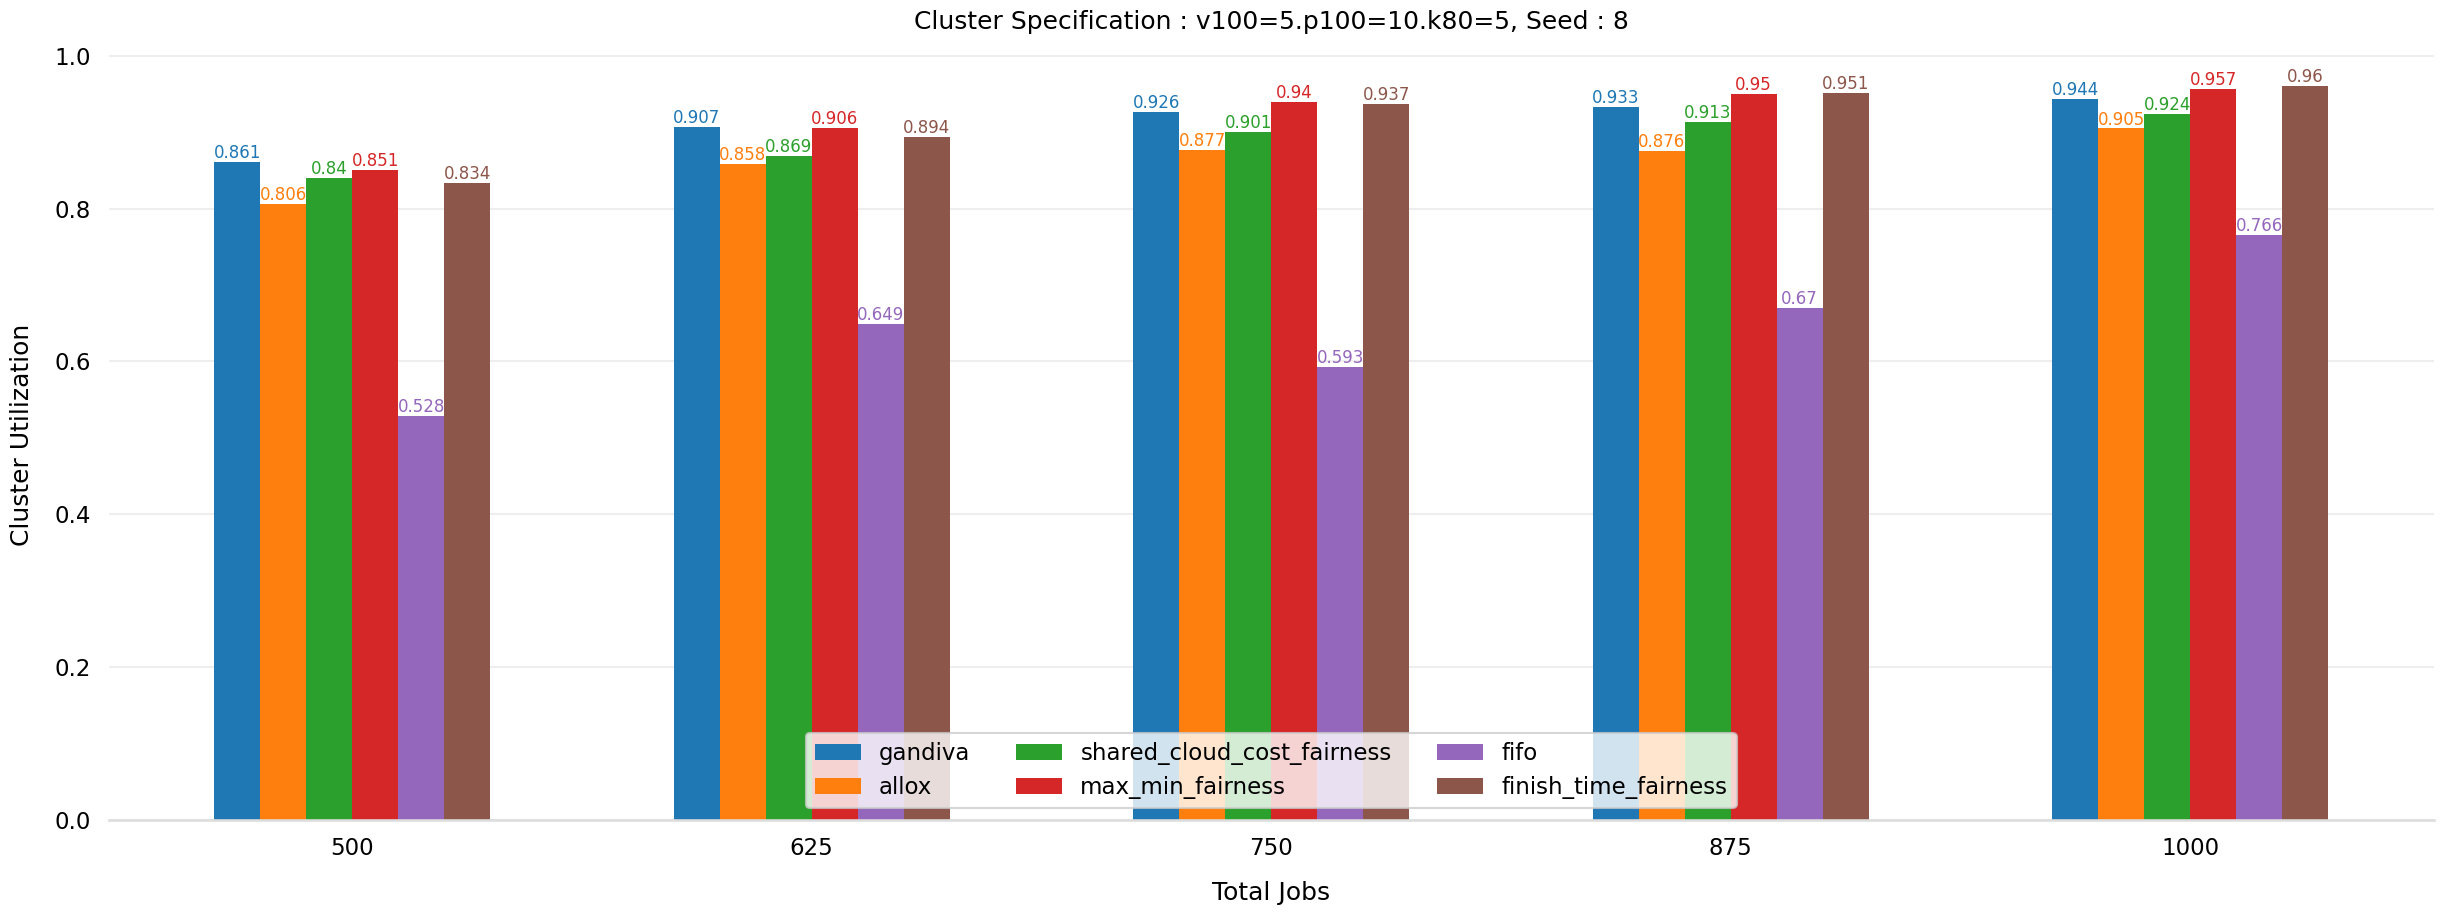

In [5]:
for cluster_spec in df_static["cluster_spec"].unique():
    for seed in df_static["seed"].unique():
        result_int = df_static.query(f'cluster_spec == "{cluster_spec}" & seed == {seed}')
        
        no_graphs = len(result_int["policy_name"].unique())

        fig, ax = plt.subplots(figsize=(30,10))
        bar_width = 0.1
        
        for idx, policy in enumerate(result_int["policy_name"].unique()):
            result = result_int.query(f'policy_name == "{policy}"')
            result = result.sort_values("total_jobs")

            x = np.arange(len(result["total_jobs"].unique()))
            y = [float(r) for r in result["utilization"]]

            ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'{policy}')
            ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
            ax.set_xticklabels(result["total_jobs"].unique())

        ax.legend(loc ="lower center", ncols=3)

        ax.set_xlabel('Total Jobs', labelpad=15)
        ax.set_ylabel('Cluster Utilization', labelpad=15)
        ax.set_title(f'Cluster Specification : {cluster_spec}, Seed : {seed}', pad=15)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#DDDDDD')
        ax.tick_params(bottom=False, left=False)
        ax.set_axisbelow(True)
        
        ax.yaxis.grid(True, color='#EEEEEE')
        ax.xaxis.grid(False)

        # For each bar in the chart, add a text label.
        for bar in ax.patches:
        # The text annotation for each bar should be its height.
            bar_value = bar.get_height()
            # Format the text with commas to separate thousands. You can do
            # any type of formatting here though.
            text = f'{bar_value:,}'
            # This will give the middle of each bar on the x-axis.
            text_x = bar.get_x() + bar.get_width() / 2
            # get_y() is where the bar starts so we add the height to it.
            text_y = bar.get_y() + bar_value
            # If we want the text to be the same color as the bar, we can
            # get the color like so:
            bar_color = bar.get_facecolor()
            # If you want a consistent color, you can just set it as a constant, e.g. #222222
            ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                    size=12)
            

how does average job completion time vary with total jobs for all policies for each seed

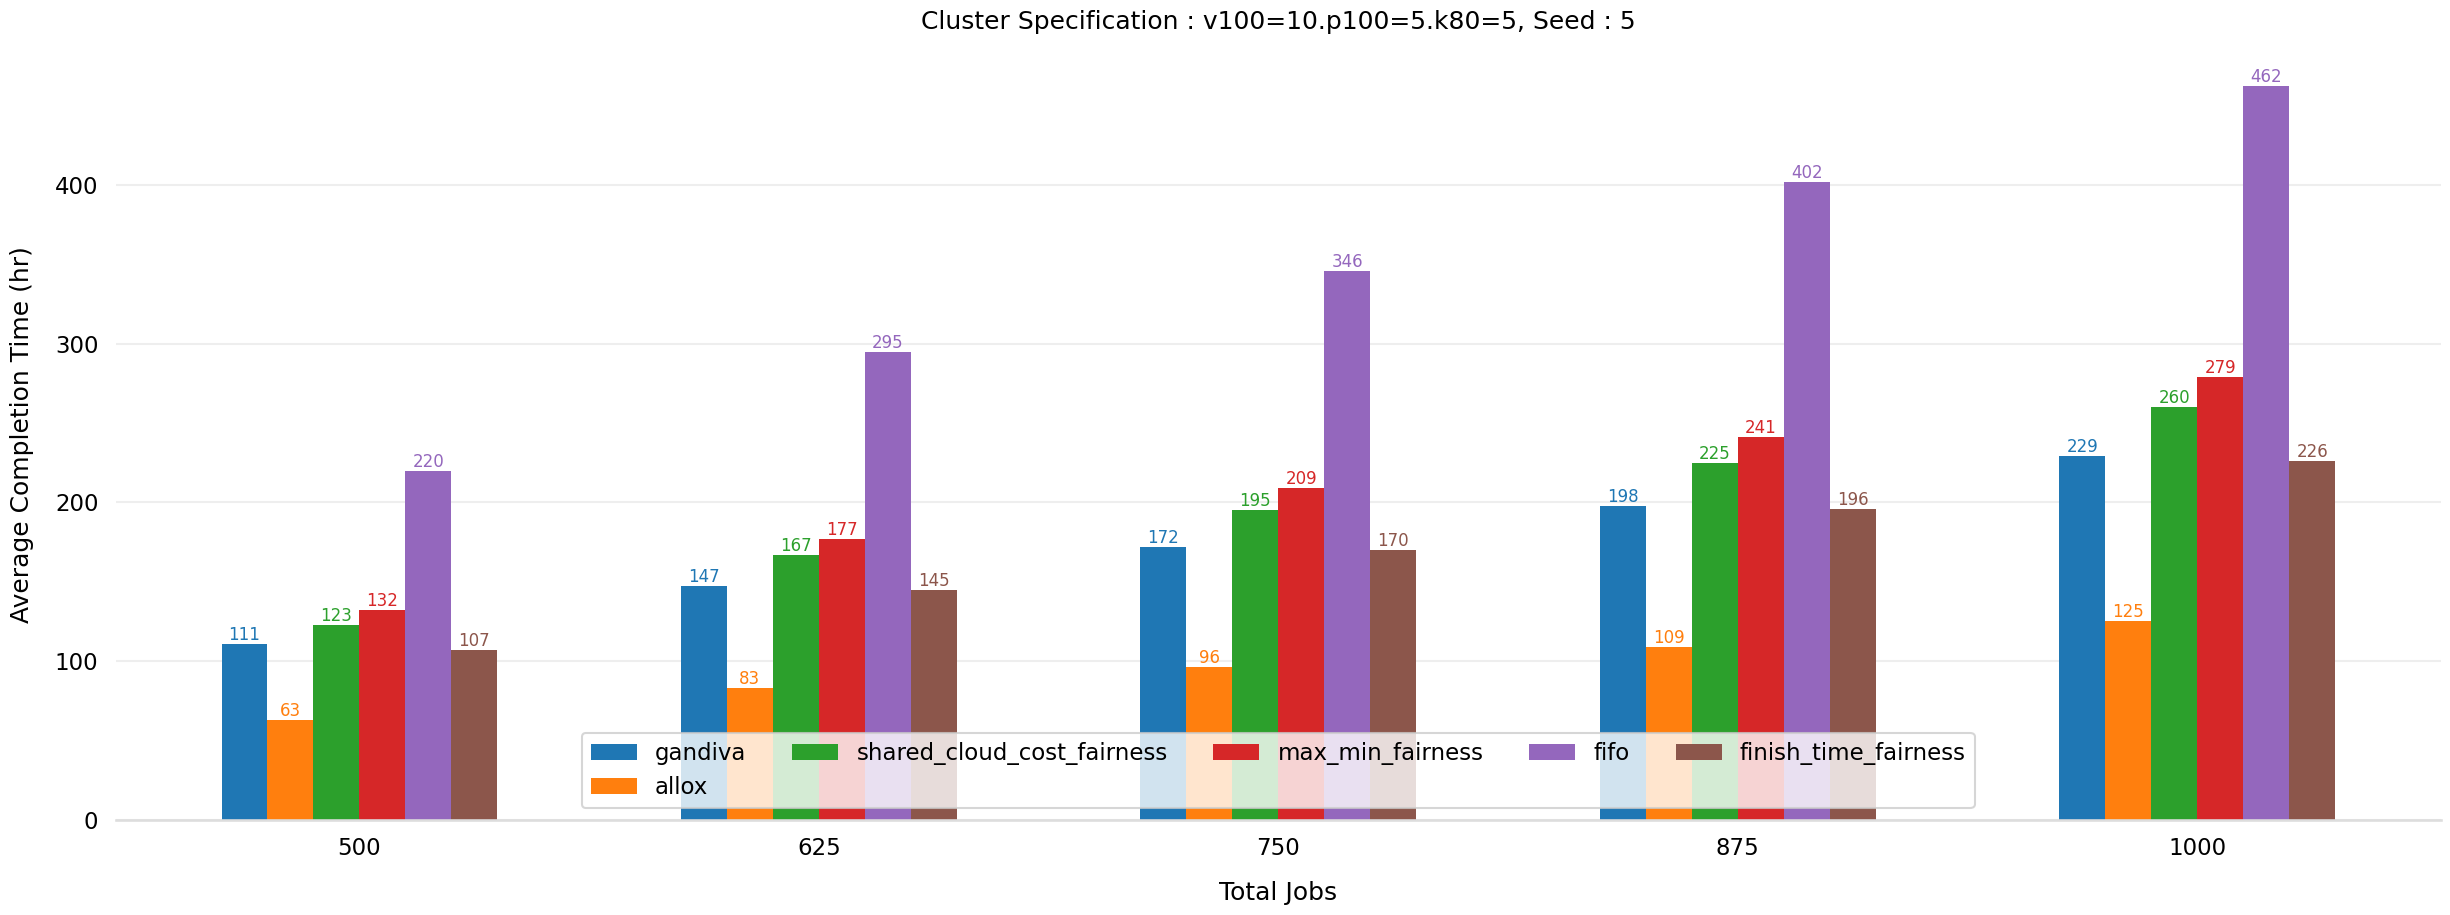

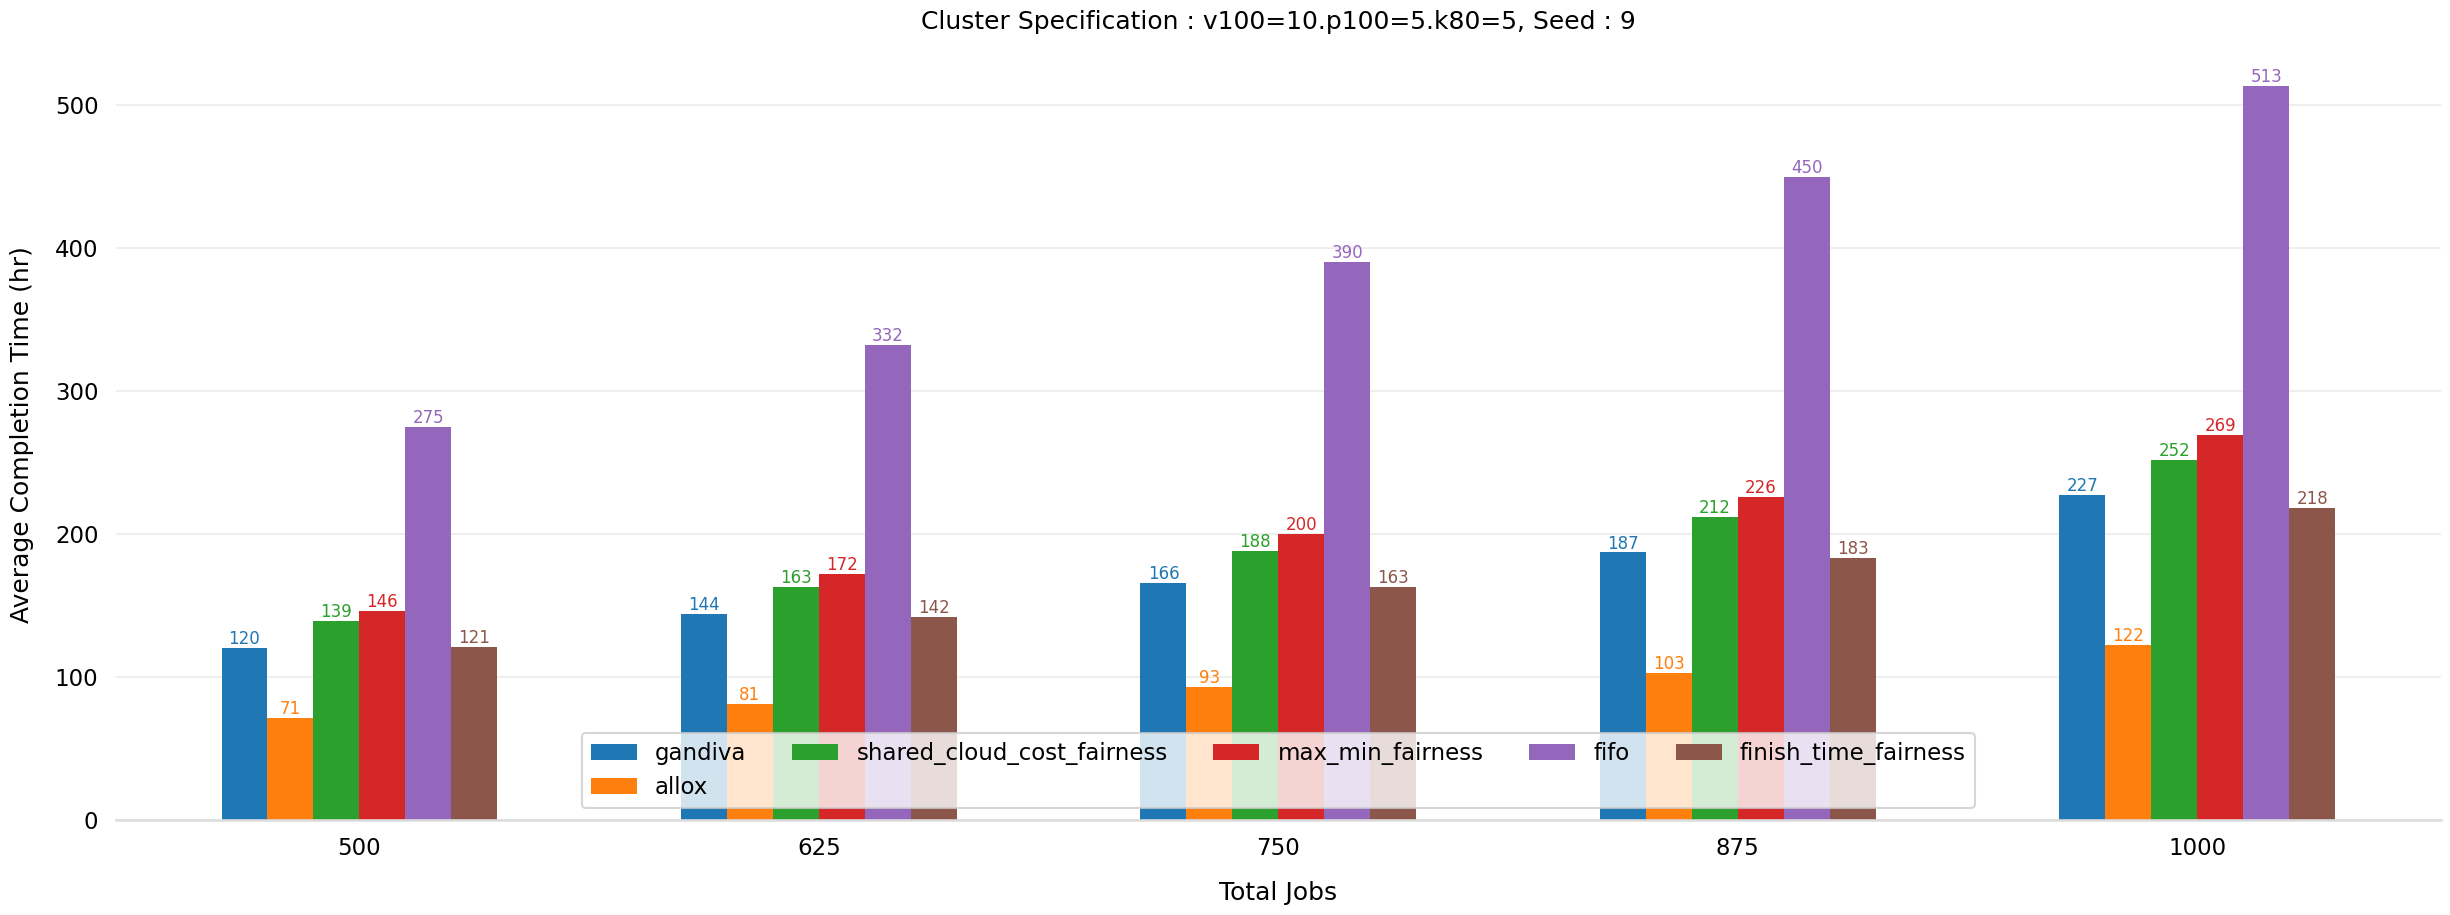

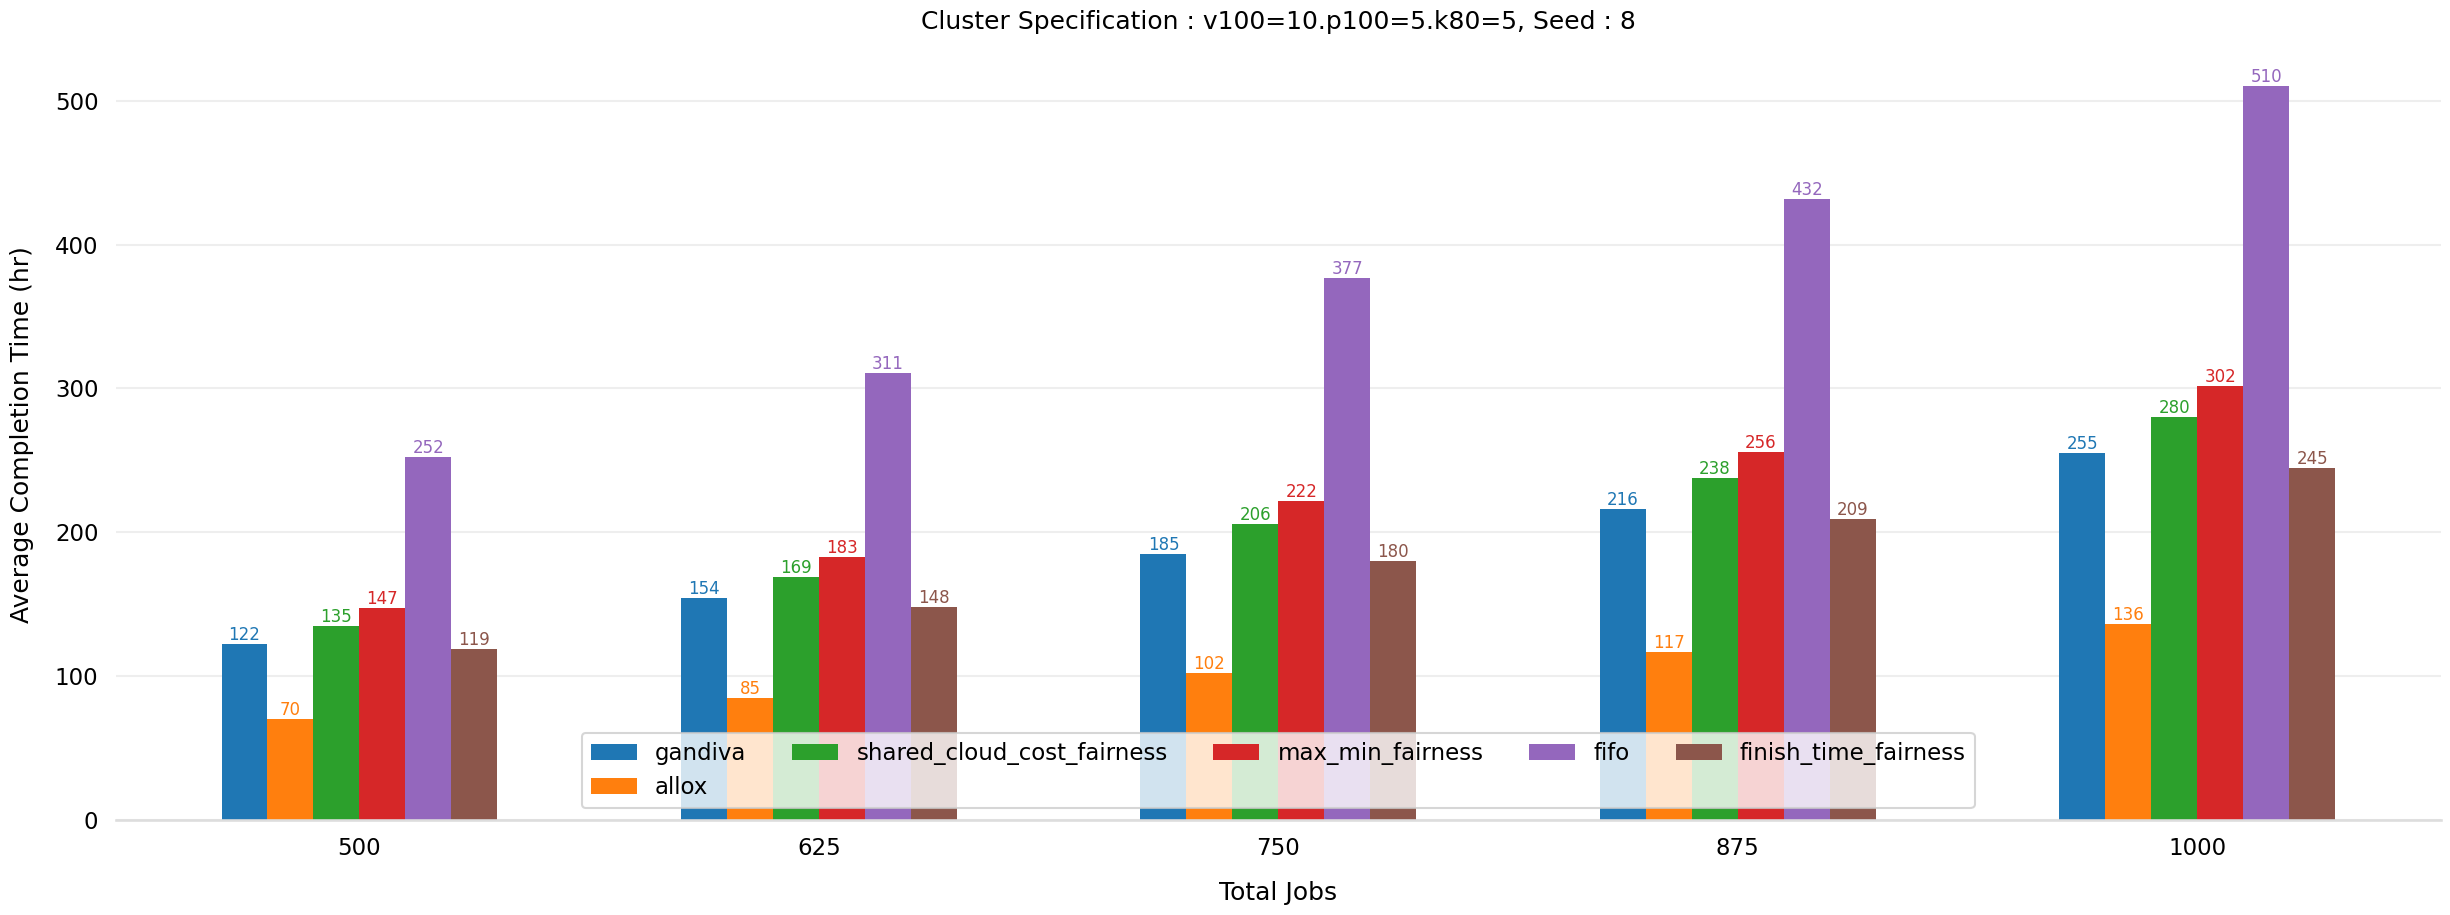

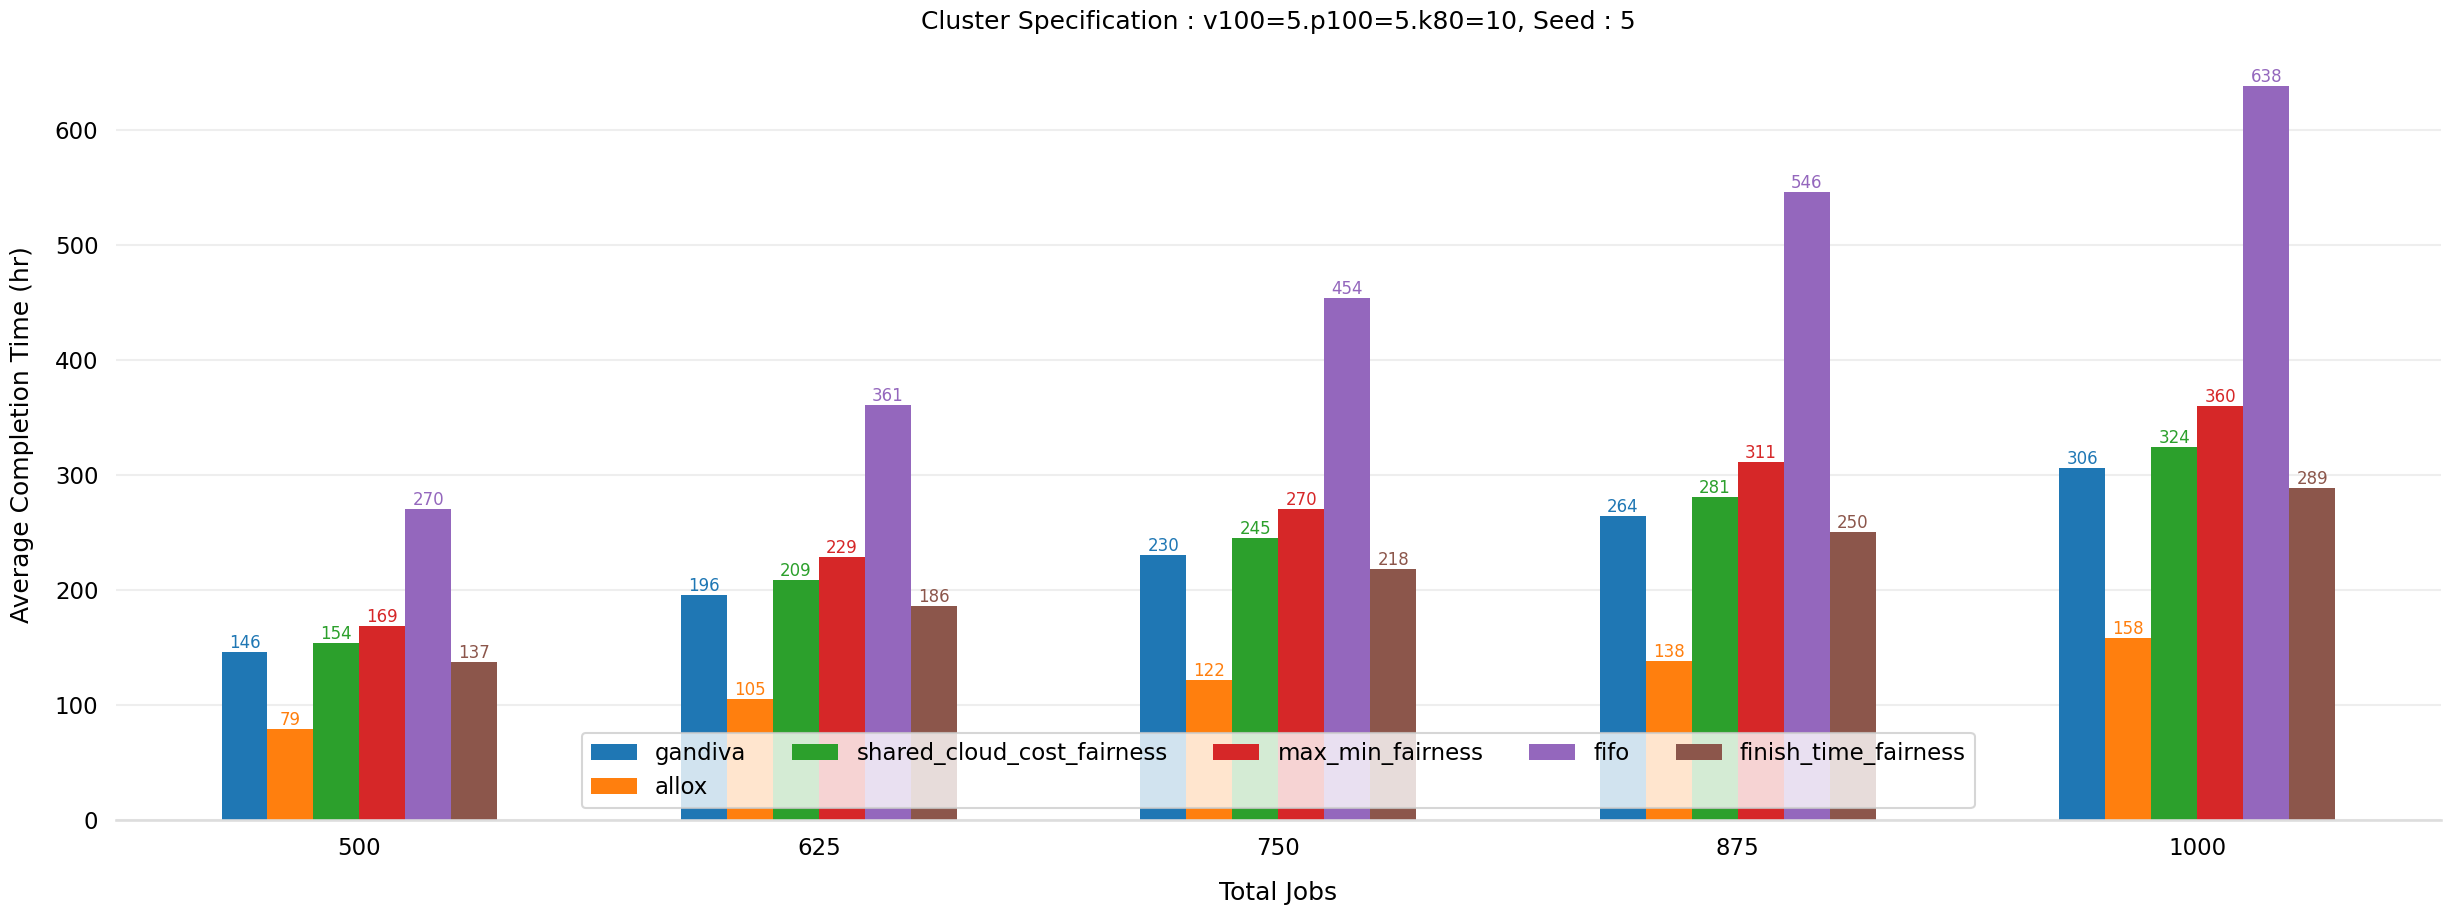

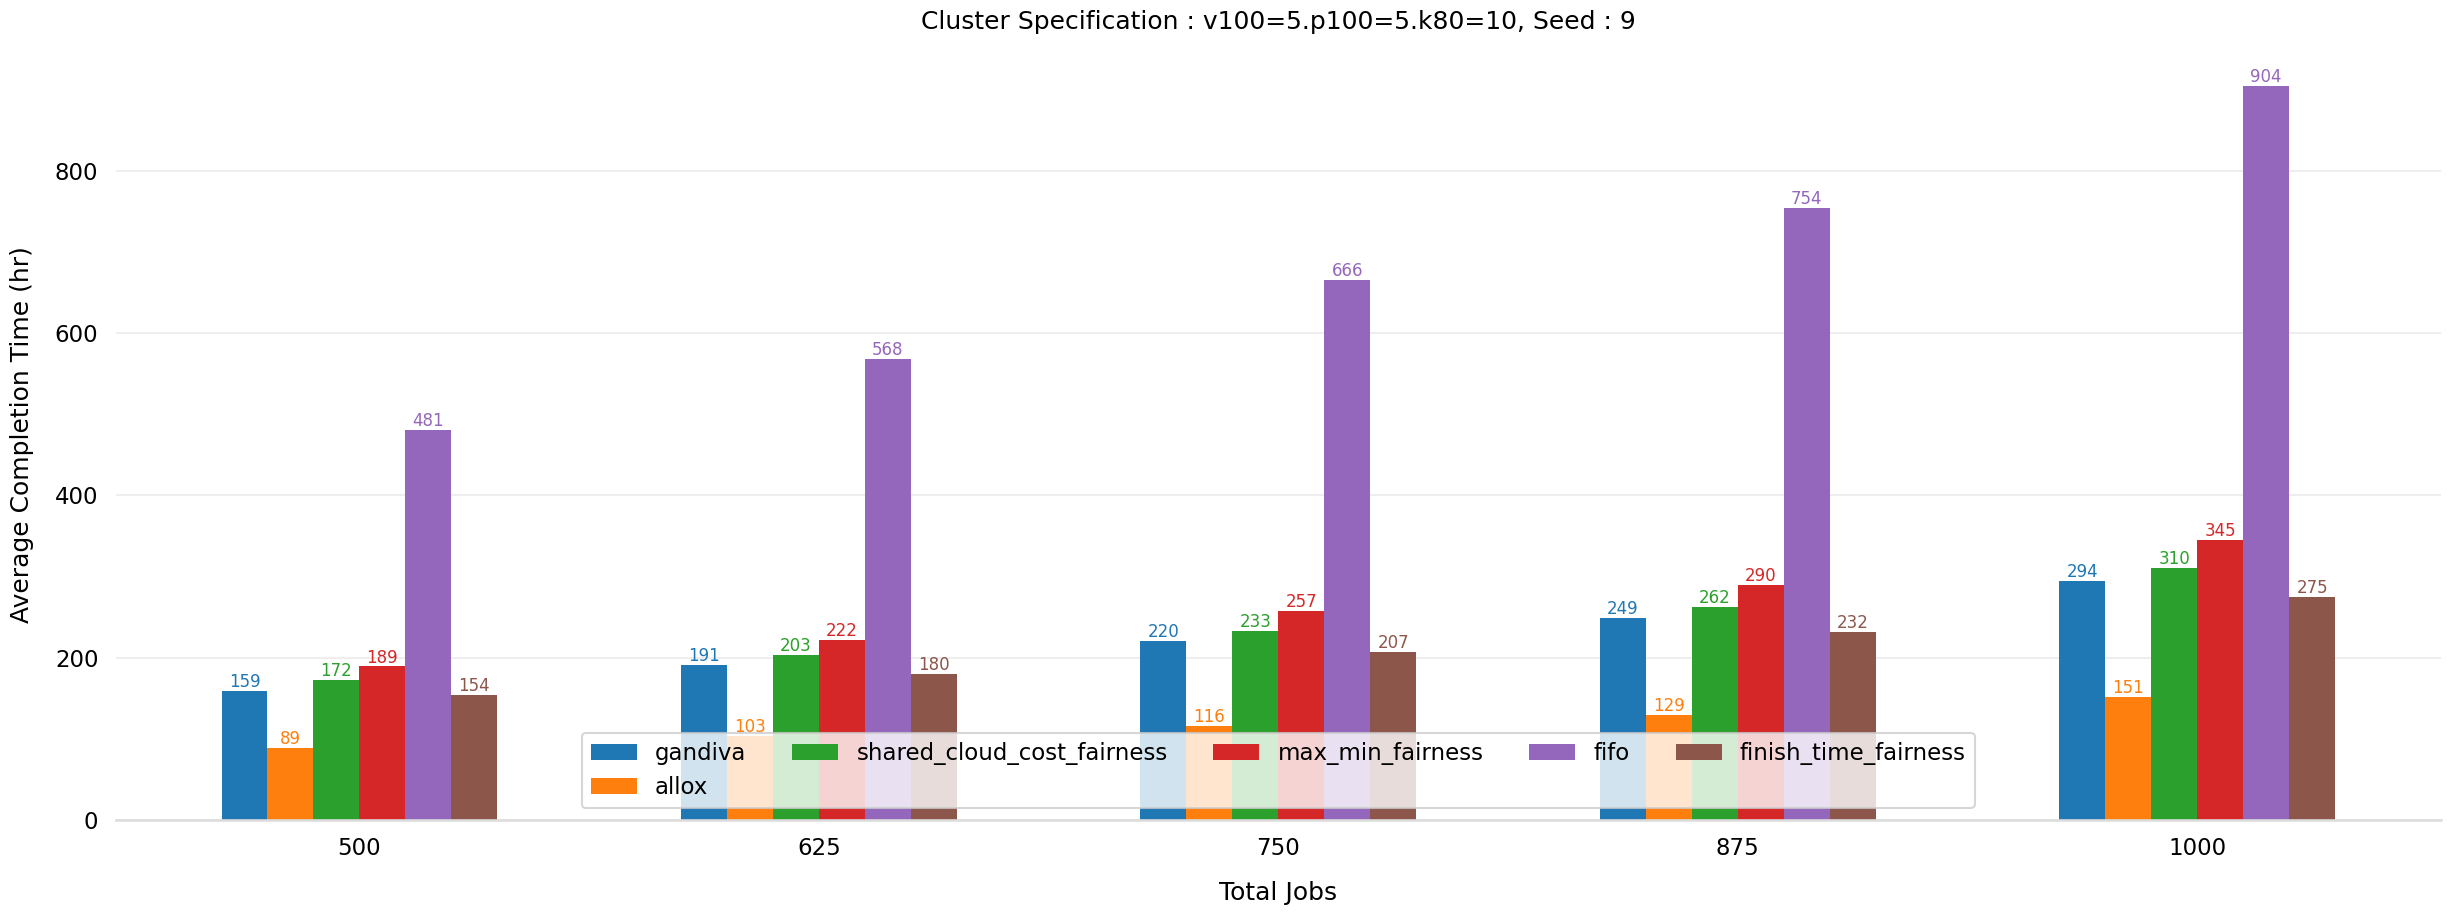

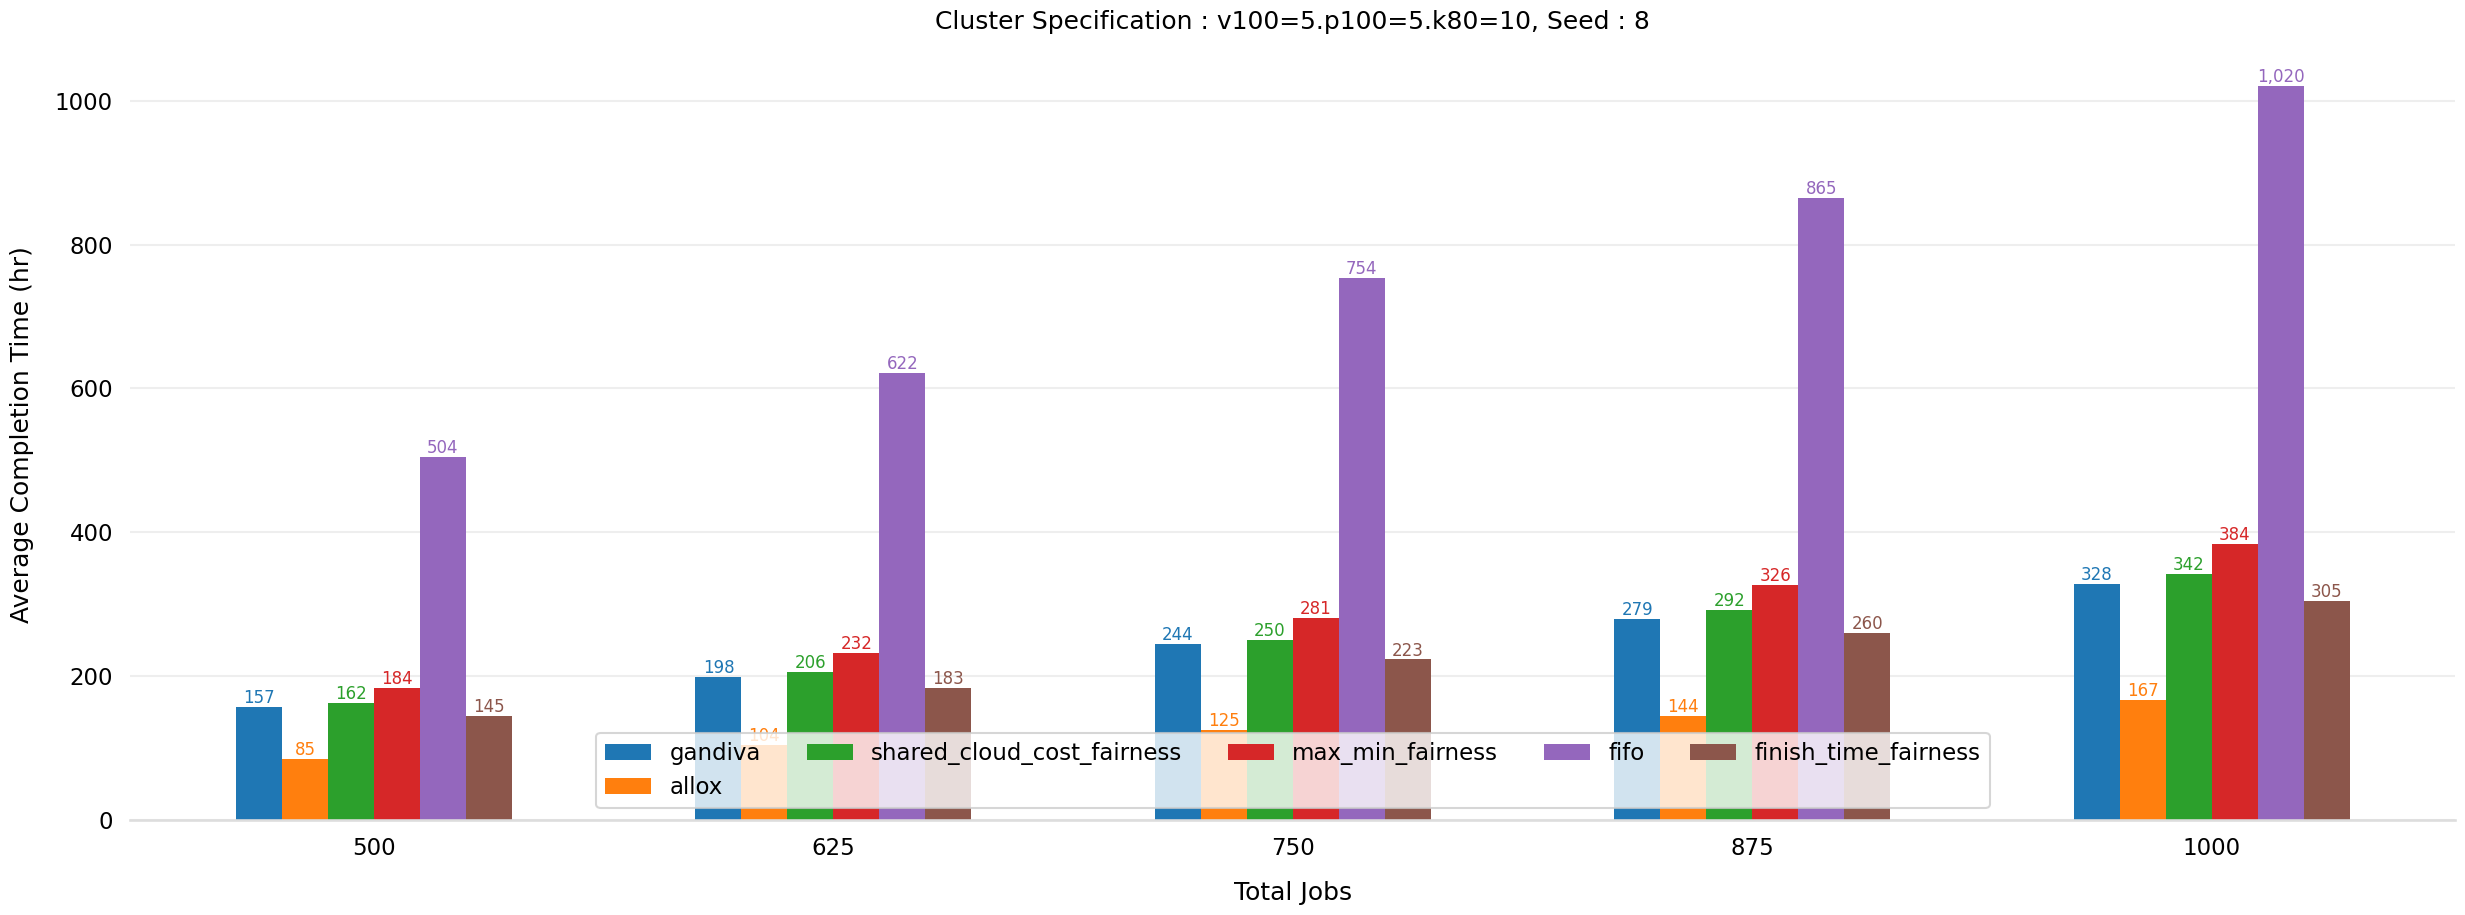

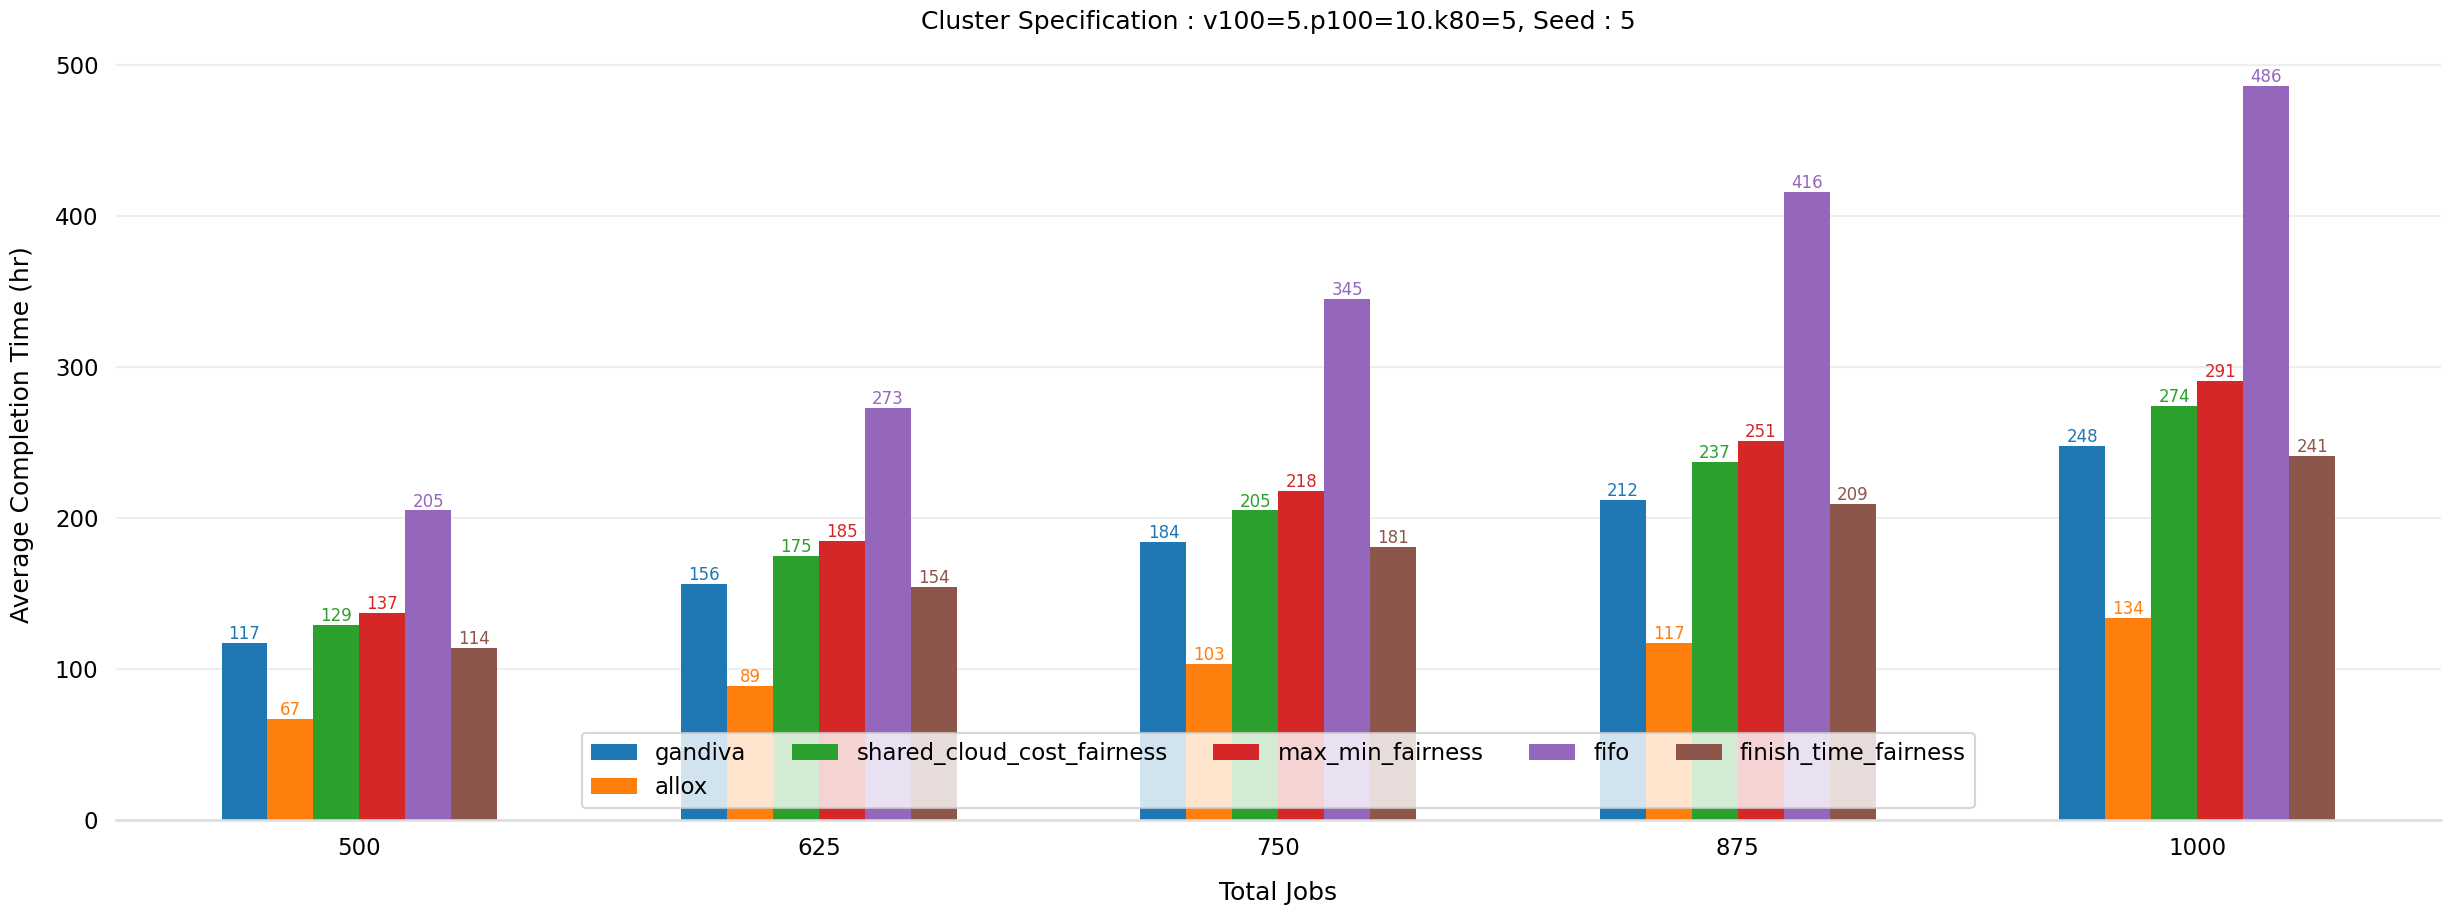

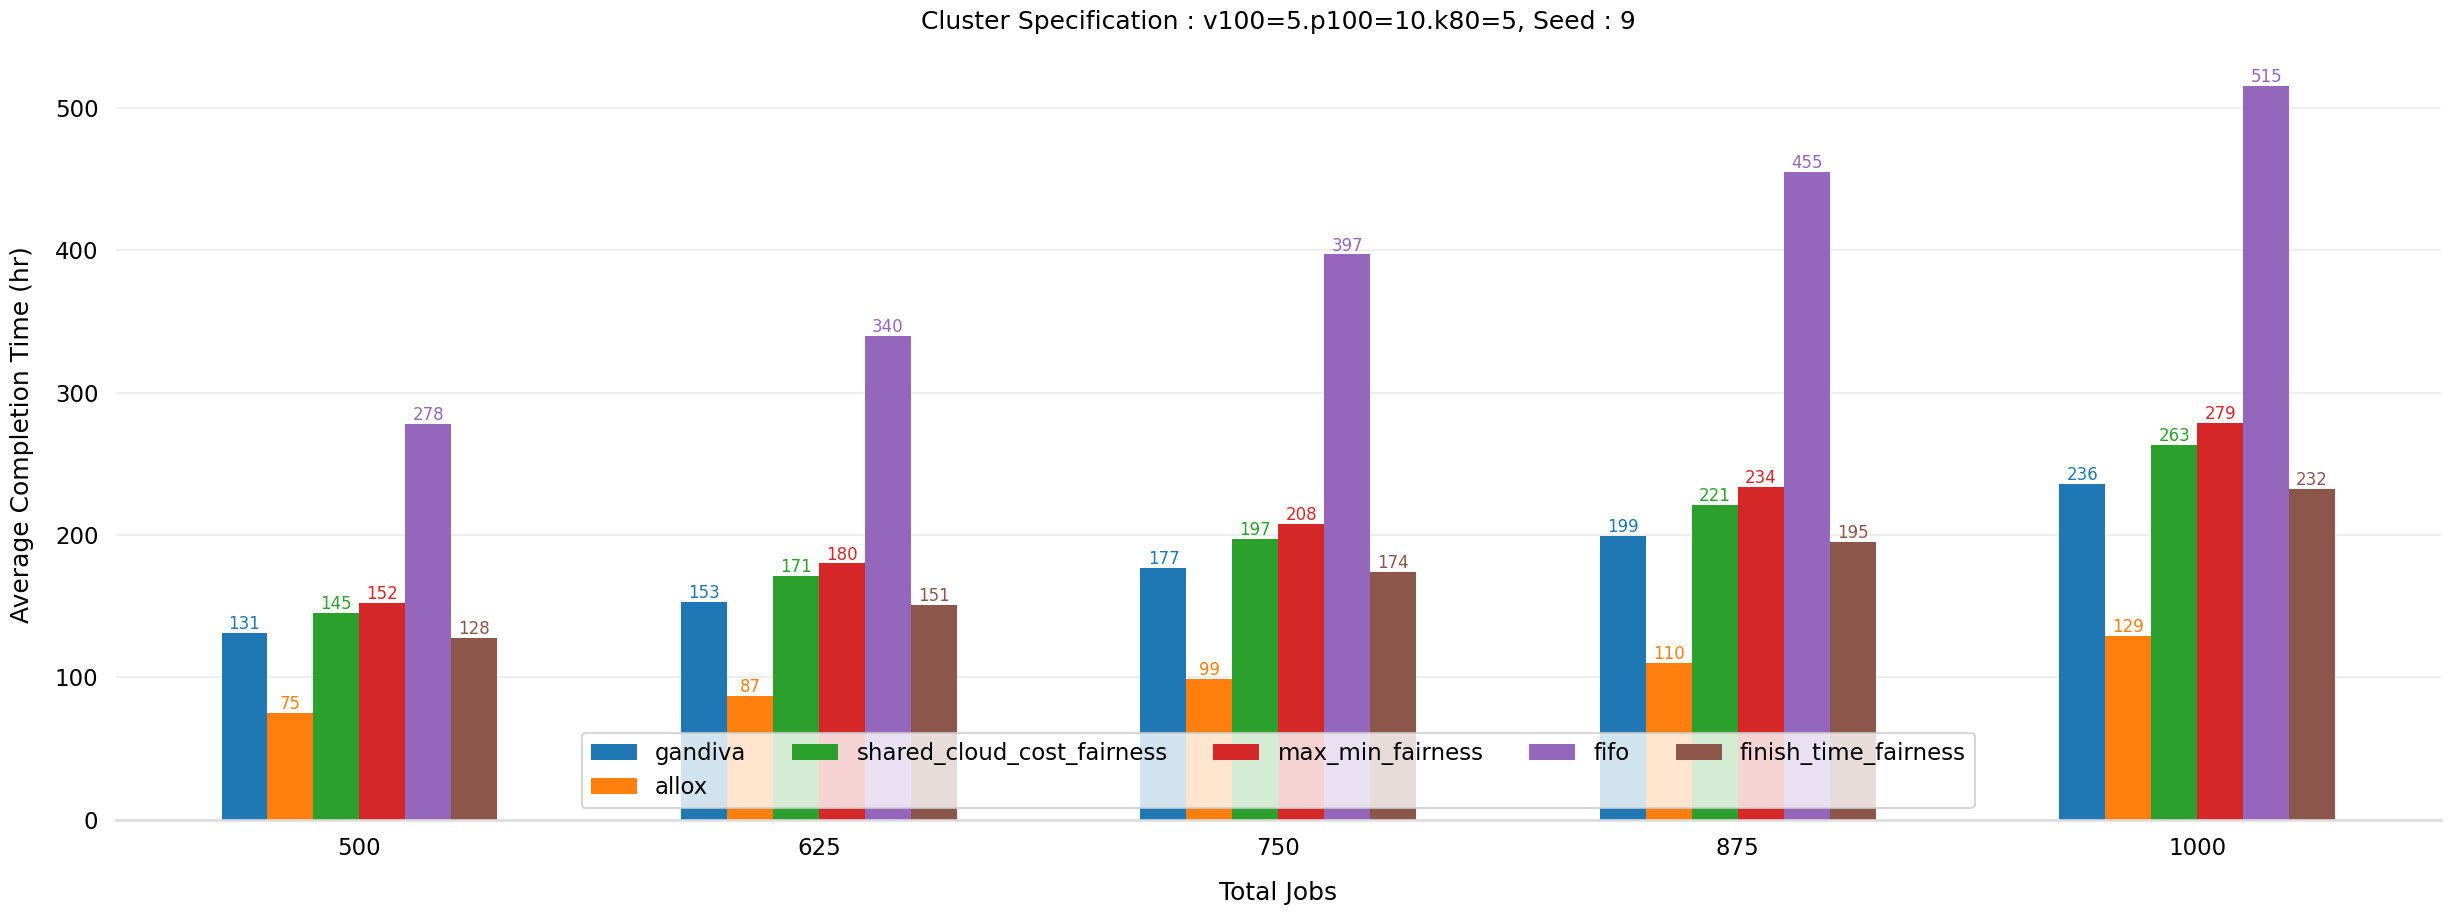

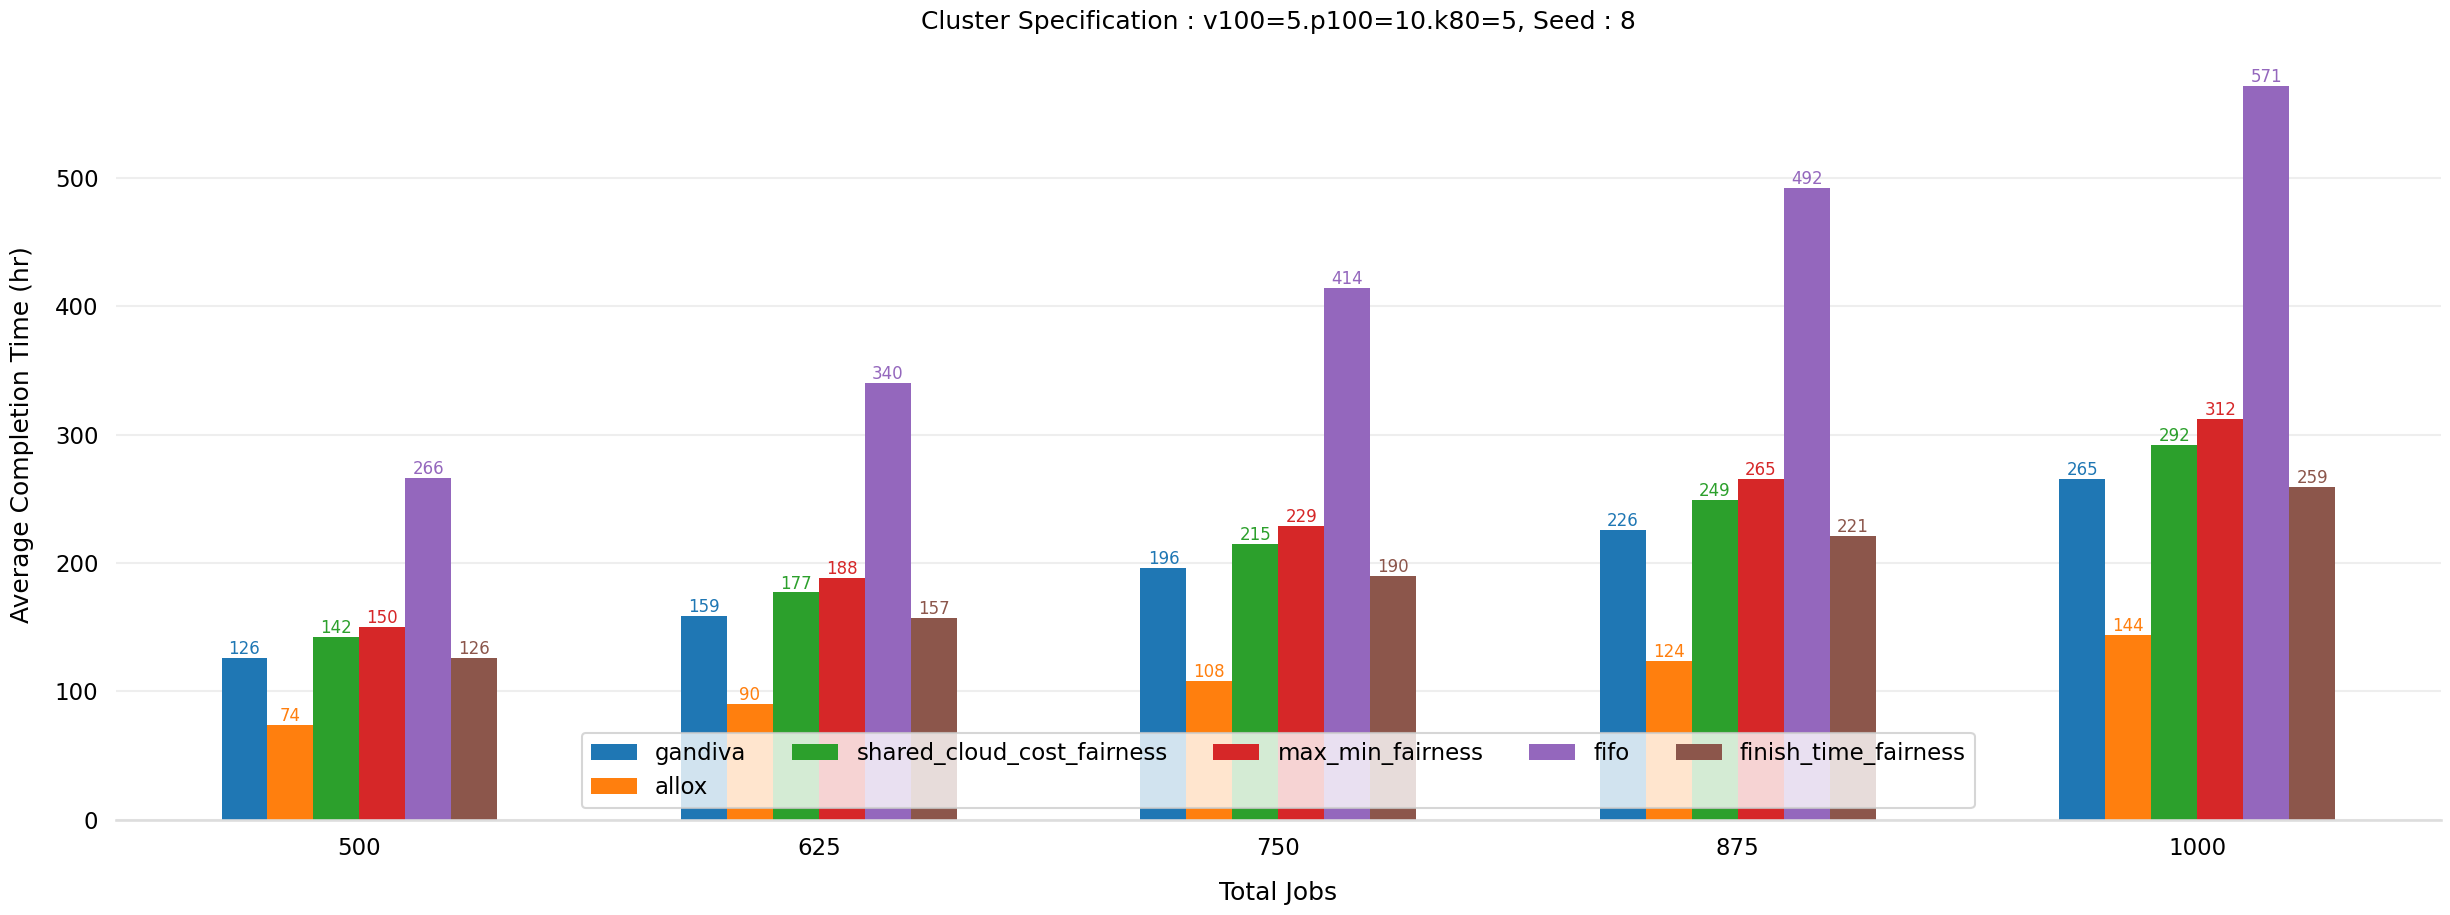

In [6]:
for cluster_spec in df_static["cluster_spec"].unique():
    for seed in df_static["seed"].unique():
        result_int = df_static.query(f'cluster_spec == "{cluster_spec}" & seed == {seed}')
        
        no_graphs = len(result_int["policy_name"].unique())

        fig, ax = plt.subplots(figsize=(30,10))
        bar_width = 0.1
        
        for idx, policy in enumerate(result_int["policy_name"].unique()):
            result = result_int.query(f'policy_name == "{policy}"')
            result = result.sort_values("total_jobs")

            x = np.arange(len(result["total_jobs"].unique()))
            y = [int(float(r.strip().split(" ")[0])/3600.0) for r in result["average_completion_time"]]

            ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'{policy}')
            ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
            ax.set_xticklabels(result["total_jobs"].unique())

        ax.legend(loc ="lower center", ncols=5)

        ax.set_xlabel('Total Jobs', labelpad=15)
        ax.set_ylabel('Average Completion Time (hr)', labelpad=15)
        ax.set_title(f'Cluster Specification : {cluster_spec}, Seed : {seed}', pad=15)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#DDDDDD')
        ax.tick_params(bottom=False, left=False)
        ax.set_axisbelow(True)
        
        ax.yaxis.grid(True, color='#EEEEEE')
        ax.xaxis.grid(False)

        # For each bar in the chart, add a text label.
        for bar in ax.patches:
        # The text annotation for each bar should be its height.
            bar_value = bar.get_height()
            # Format the text with commas to separate thousands. You can do
            # any type of formatting here though.
            text = f'{bar_value:,}'
            # This will give the middle of each bar on the x-axis.
            text_x = bar.get_x() + bar.get_width() / 2
            # get_y() is where the bar starts so we add the height to it.
            text_y = bar.get_y() + bar_value
            # If we want the text to be the same color as the bar, we can
            # get the color like so:
            bar_color = bar.get_facecolor()
            # If you want a consistent color, you can just set it as a constant, e.g. #222222
            ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                    size=12)
            

how does the total cost vary for all policies for different seeds

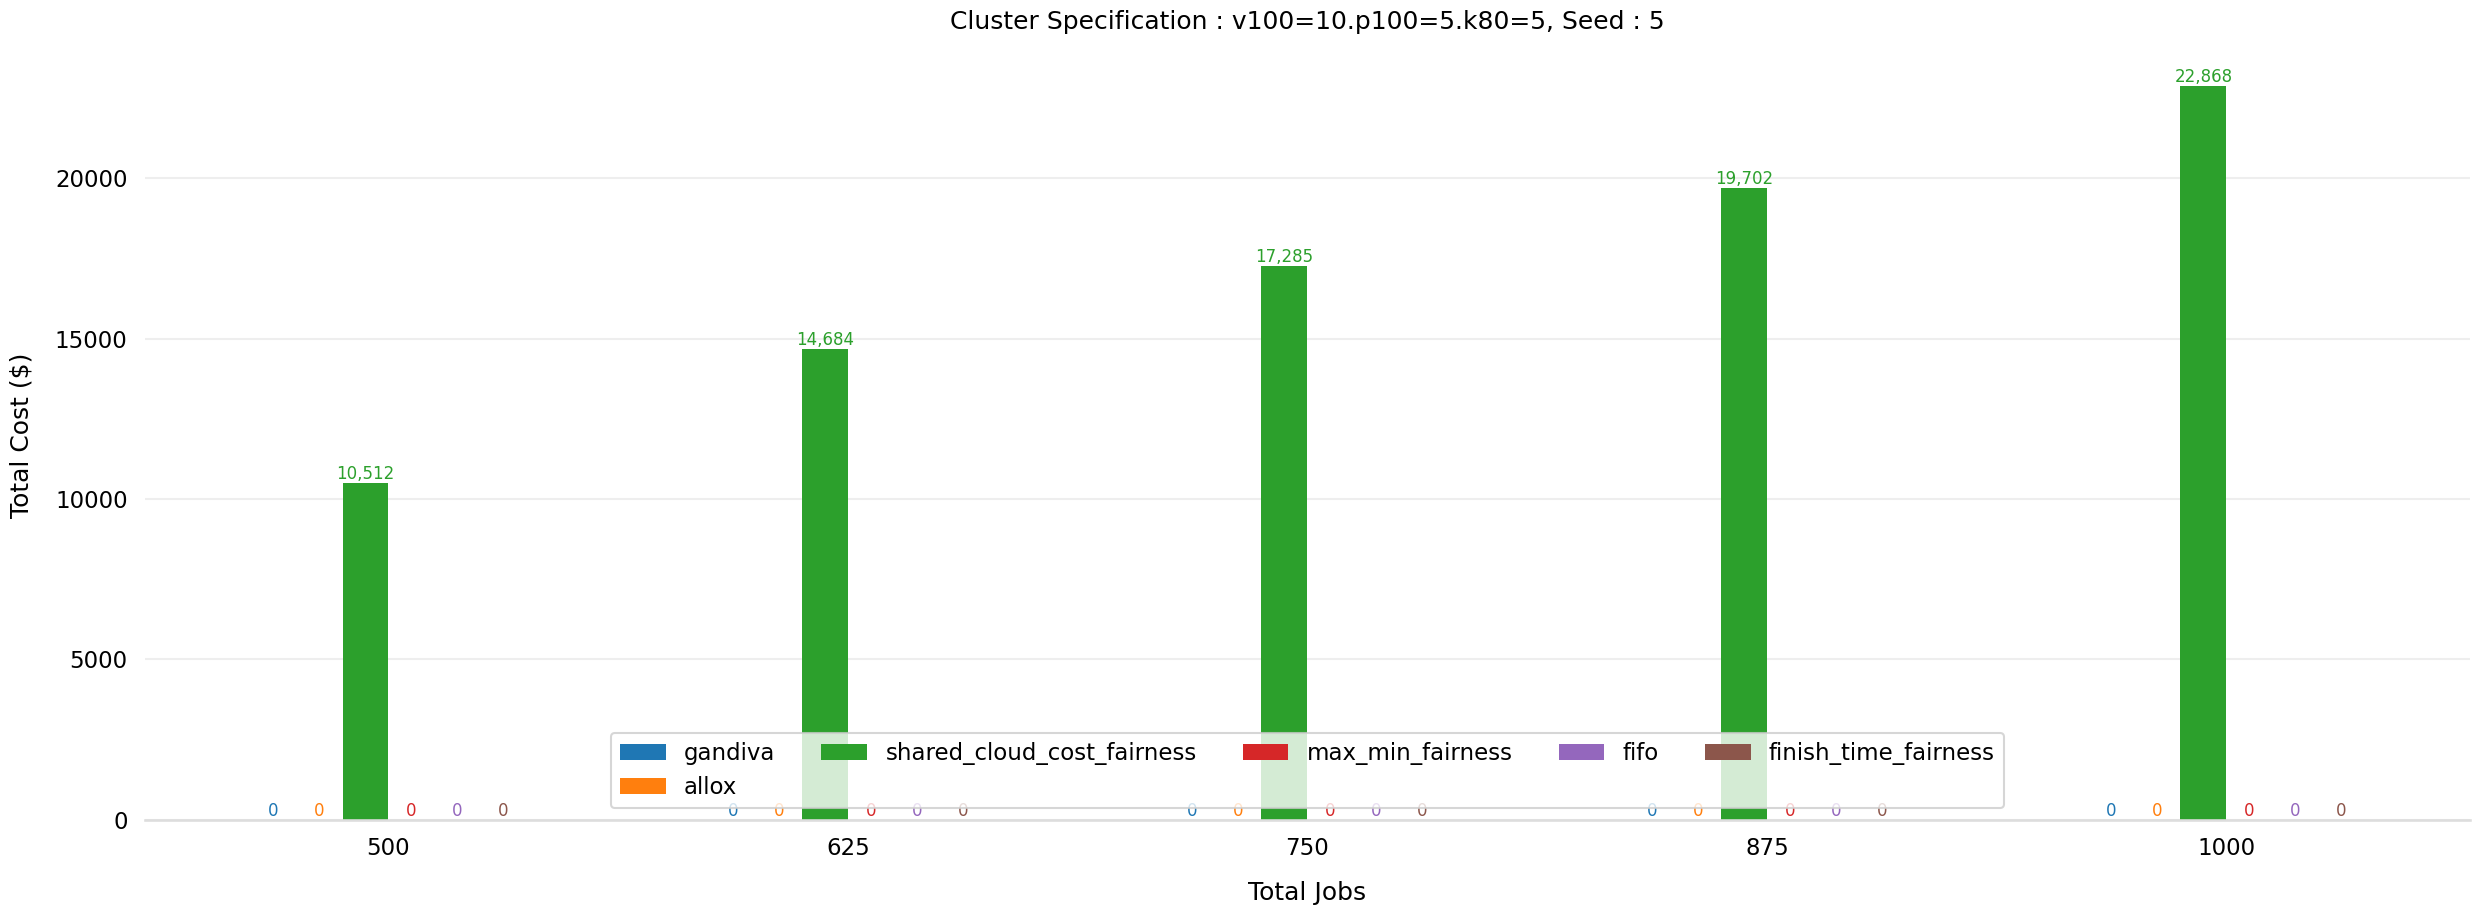

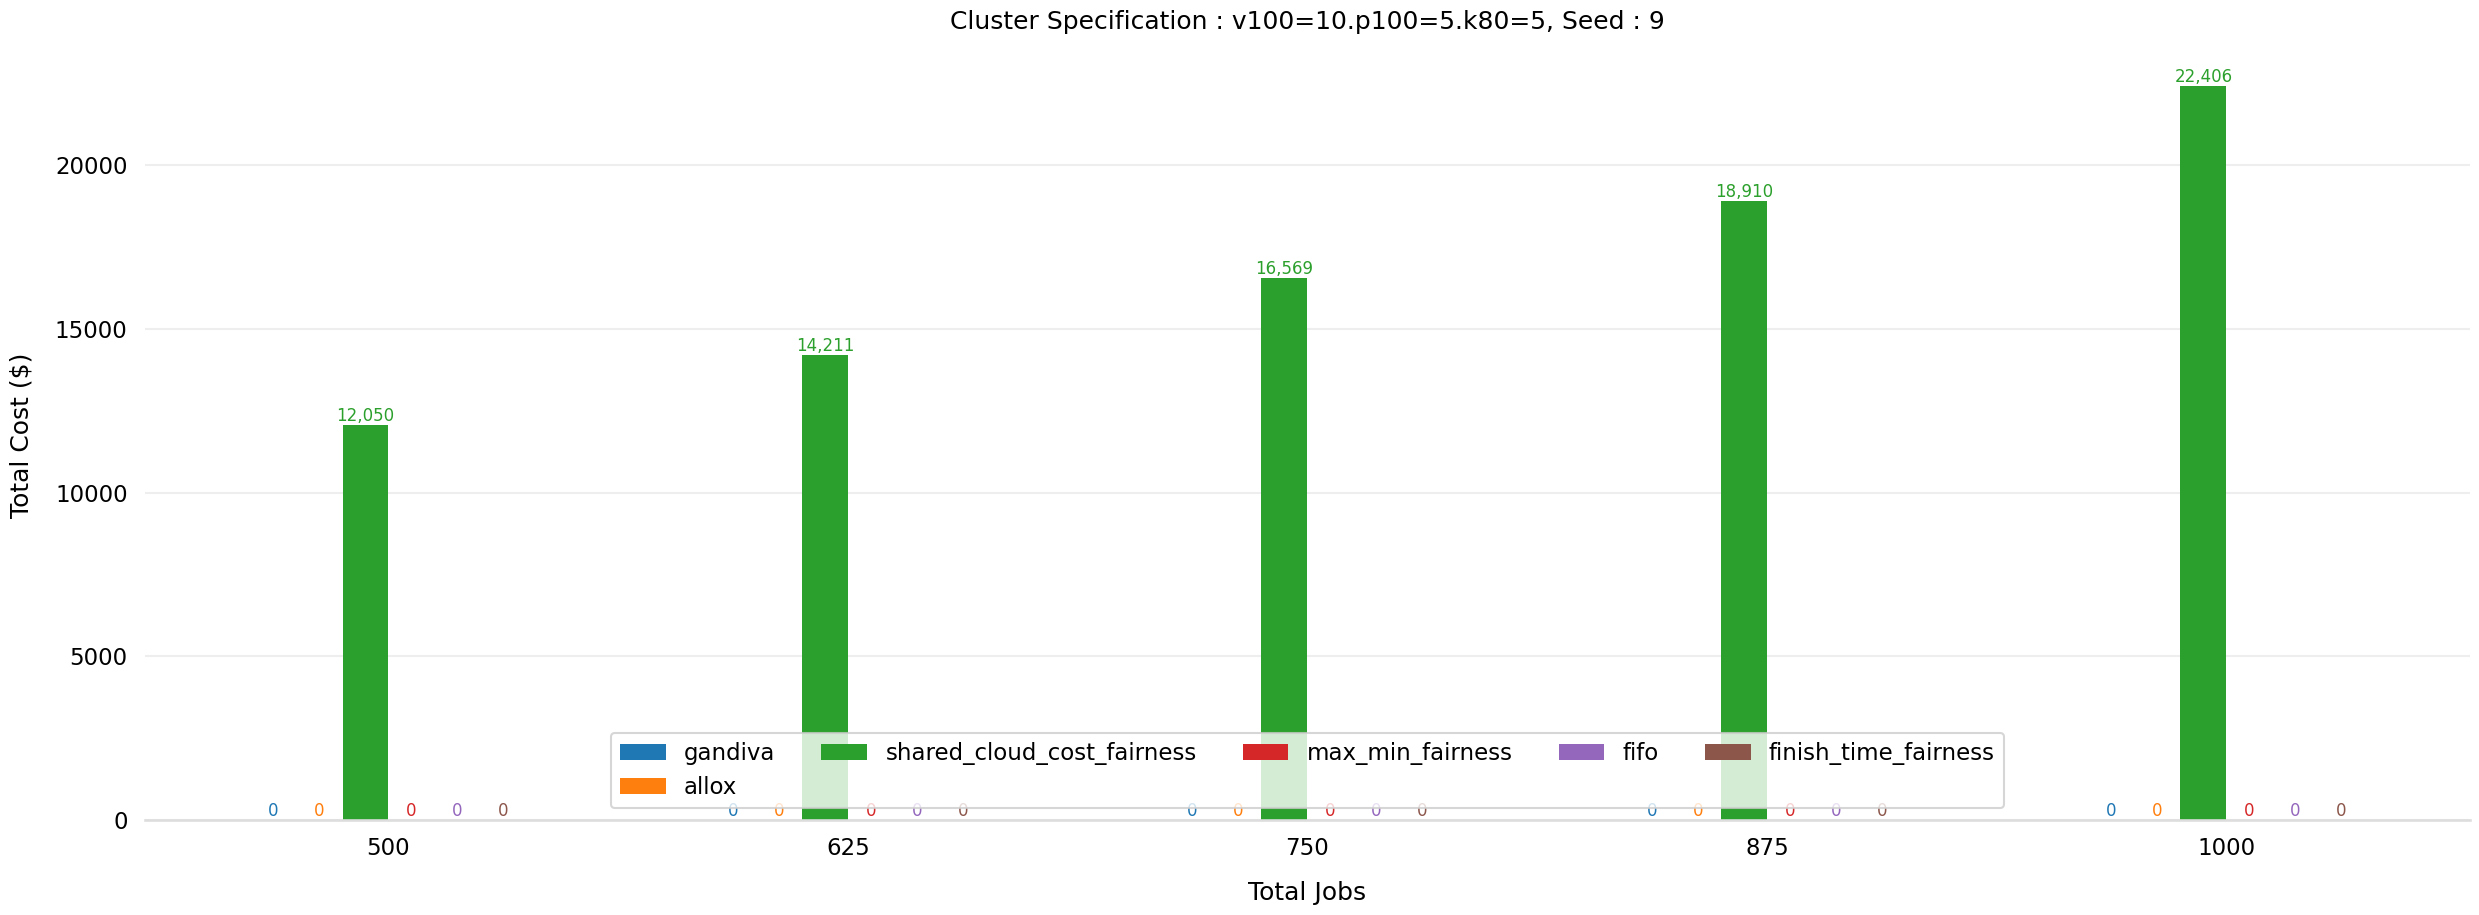

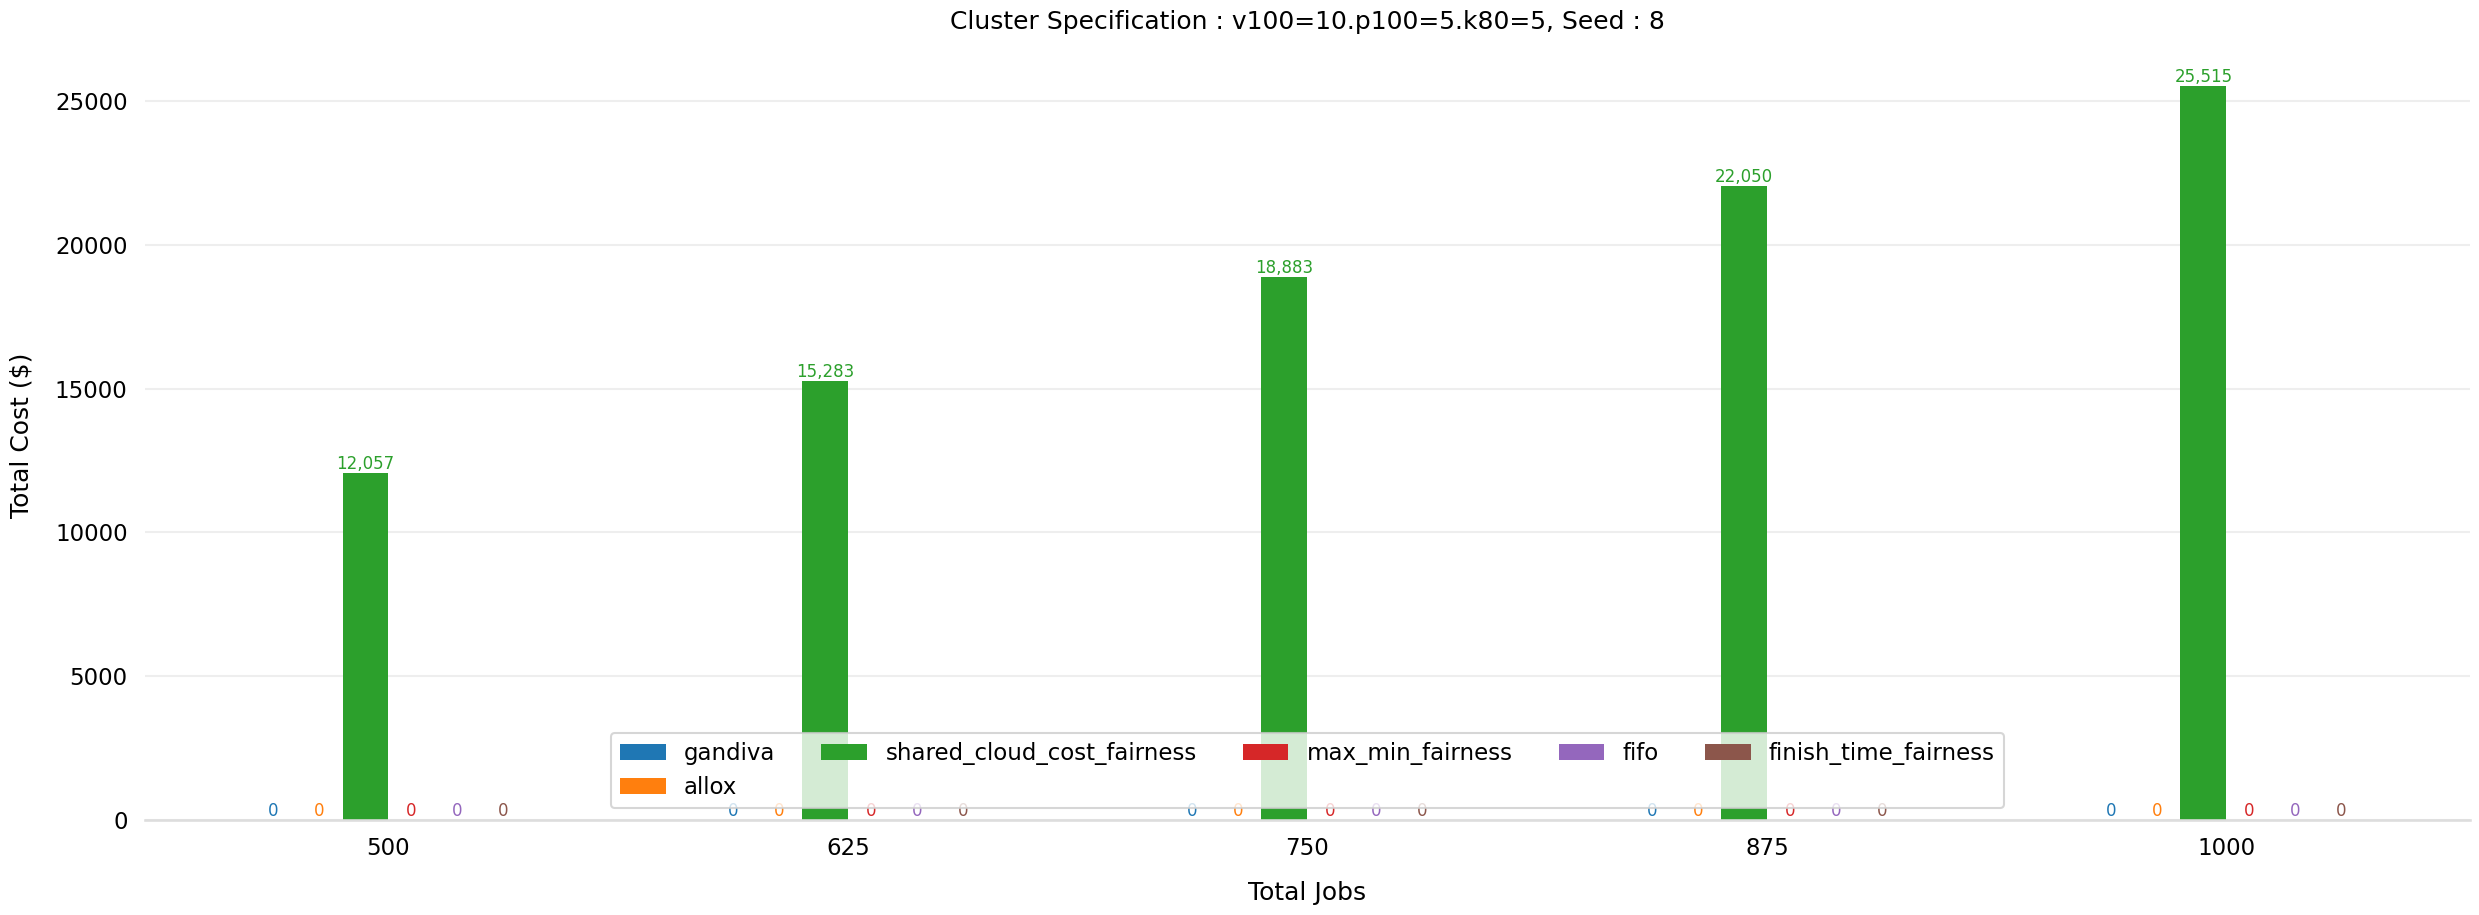

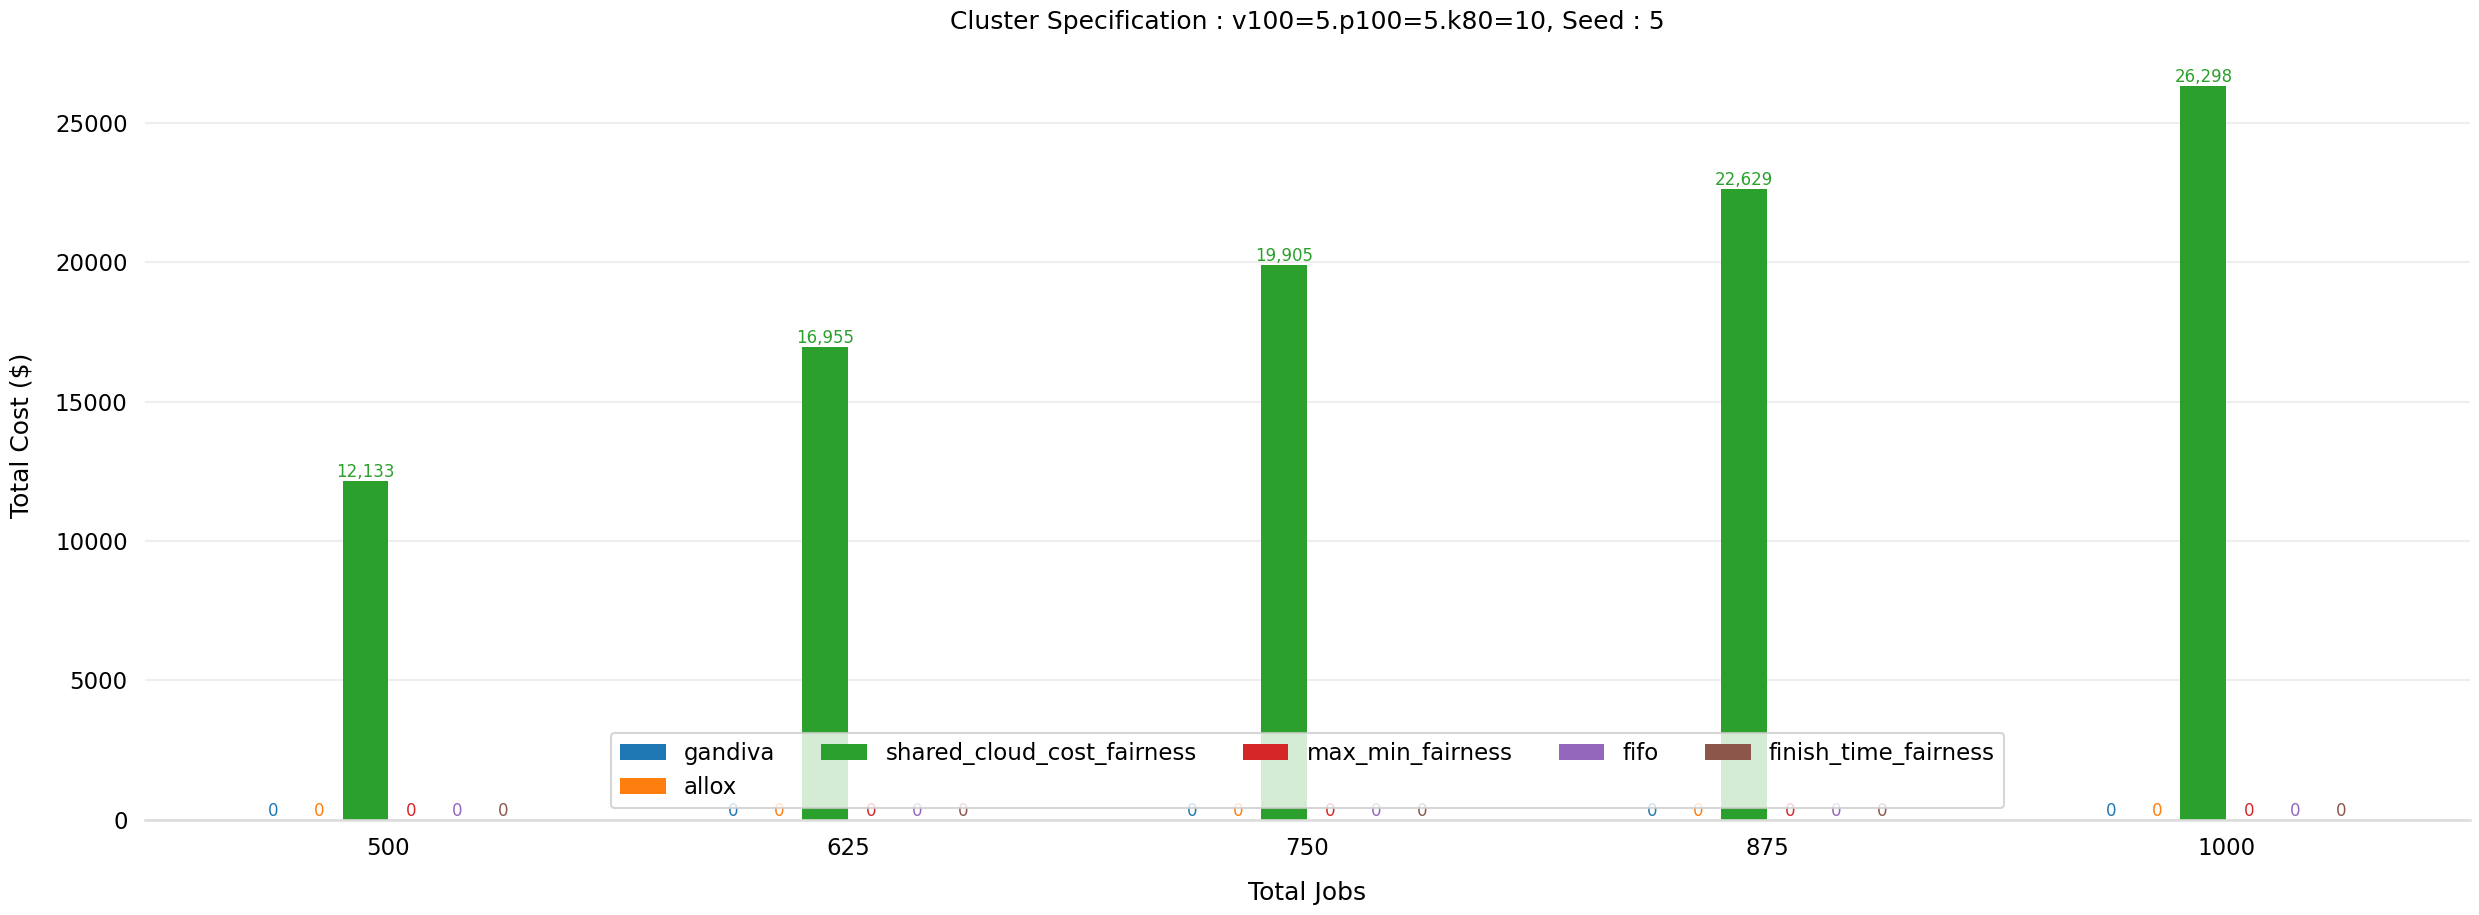

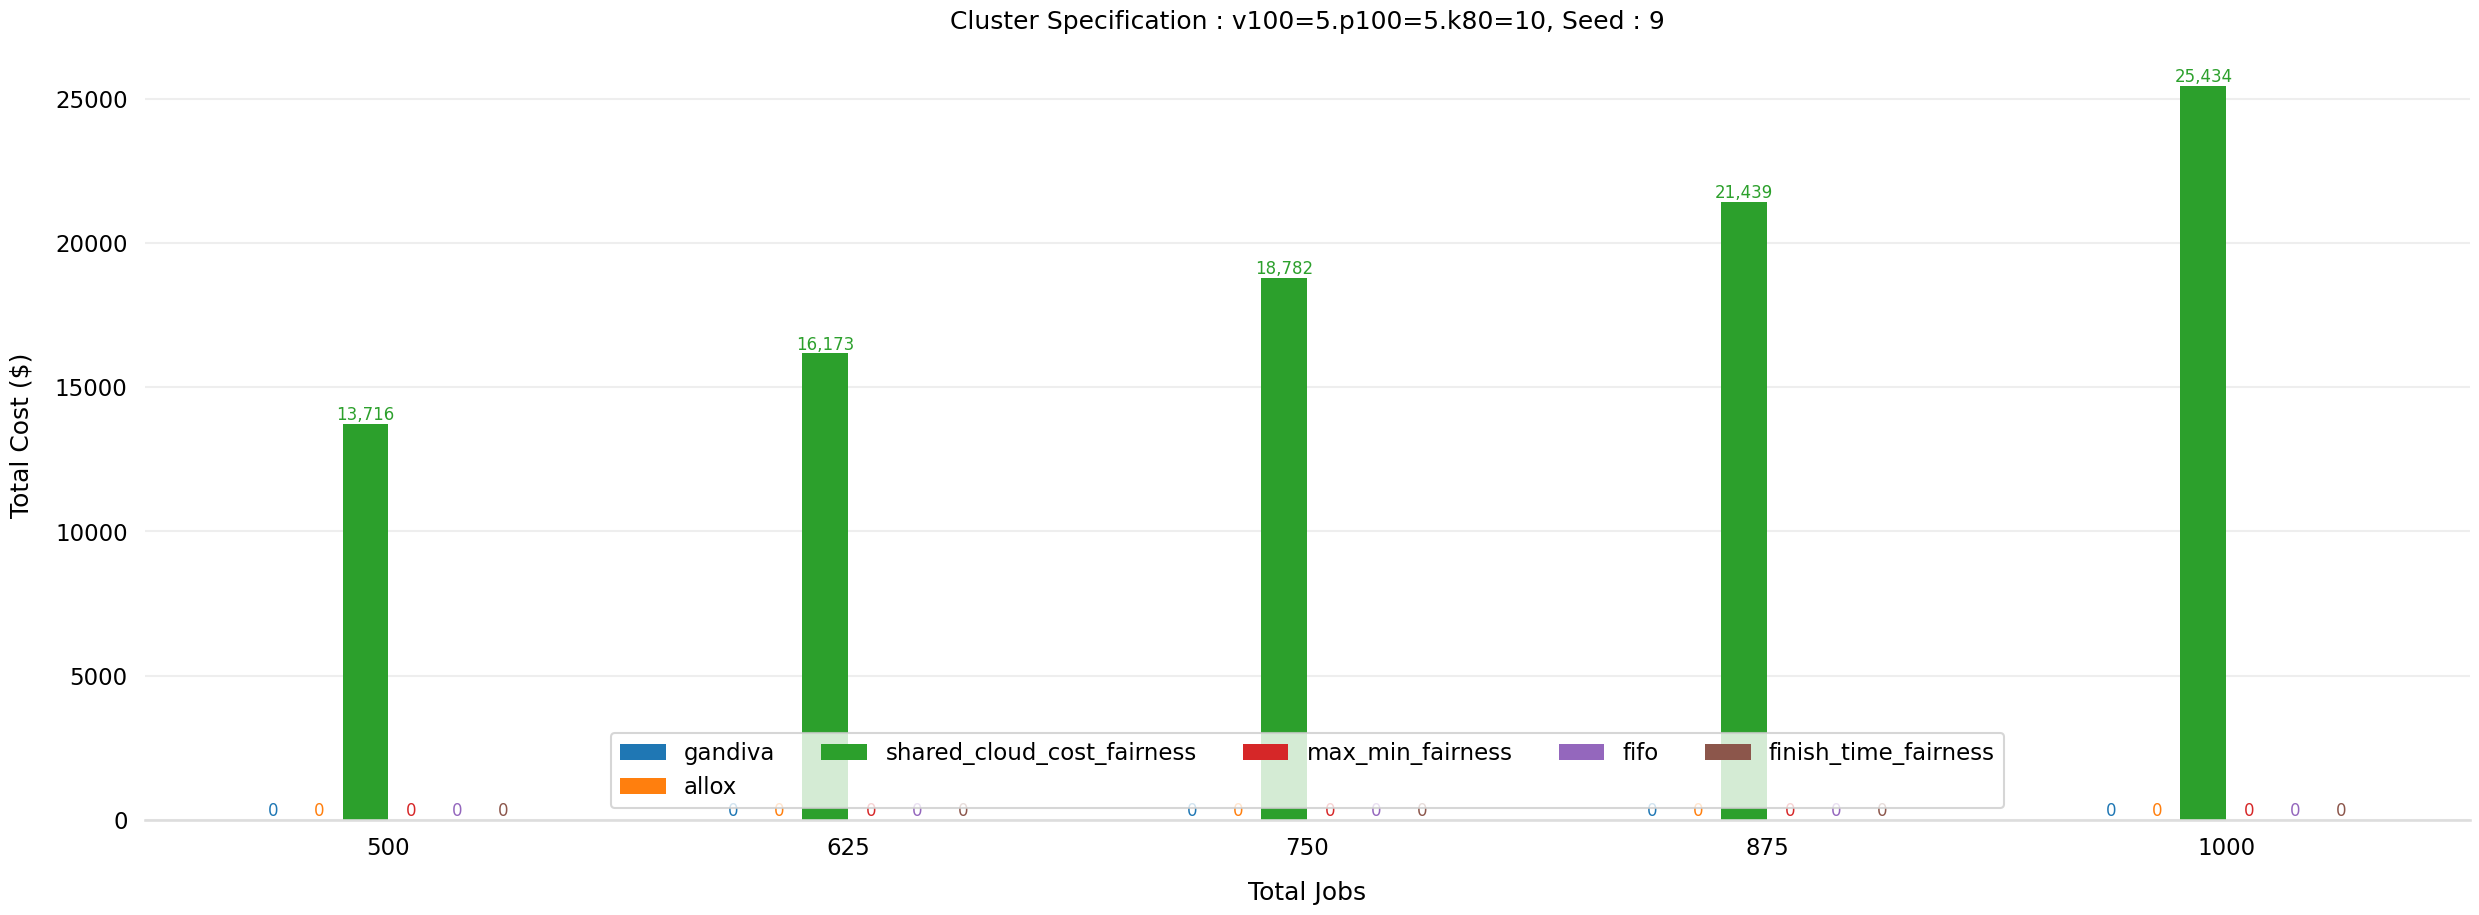

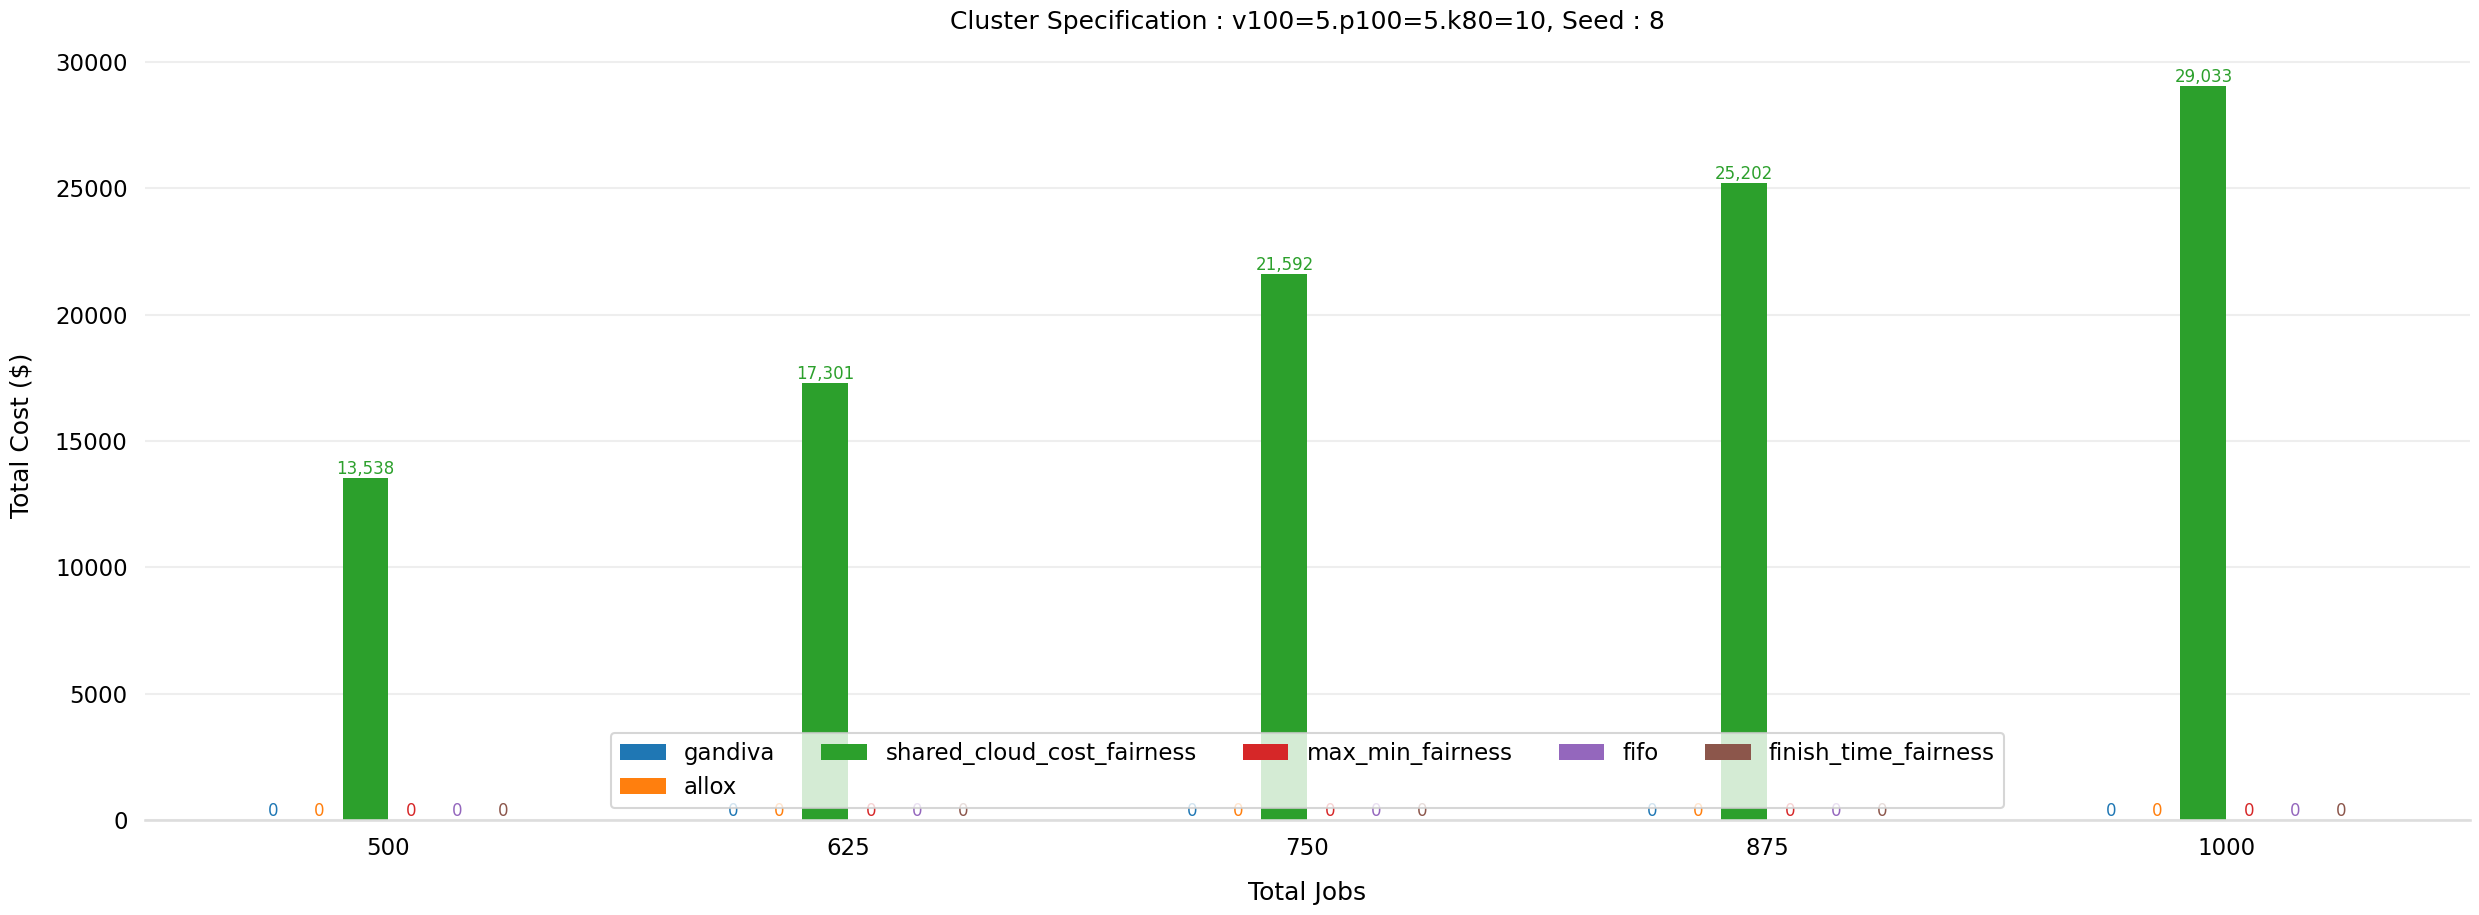

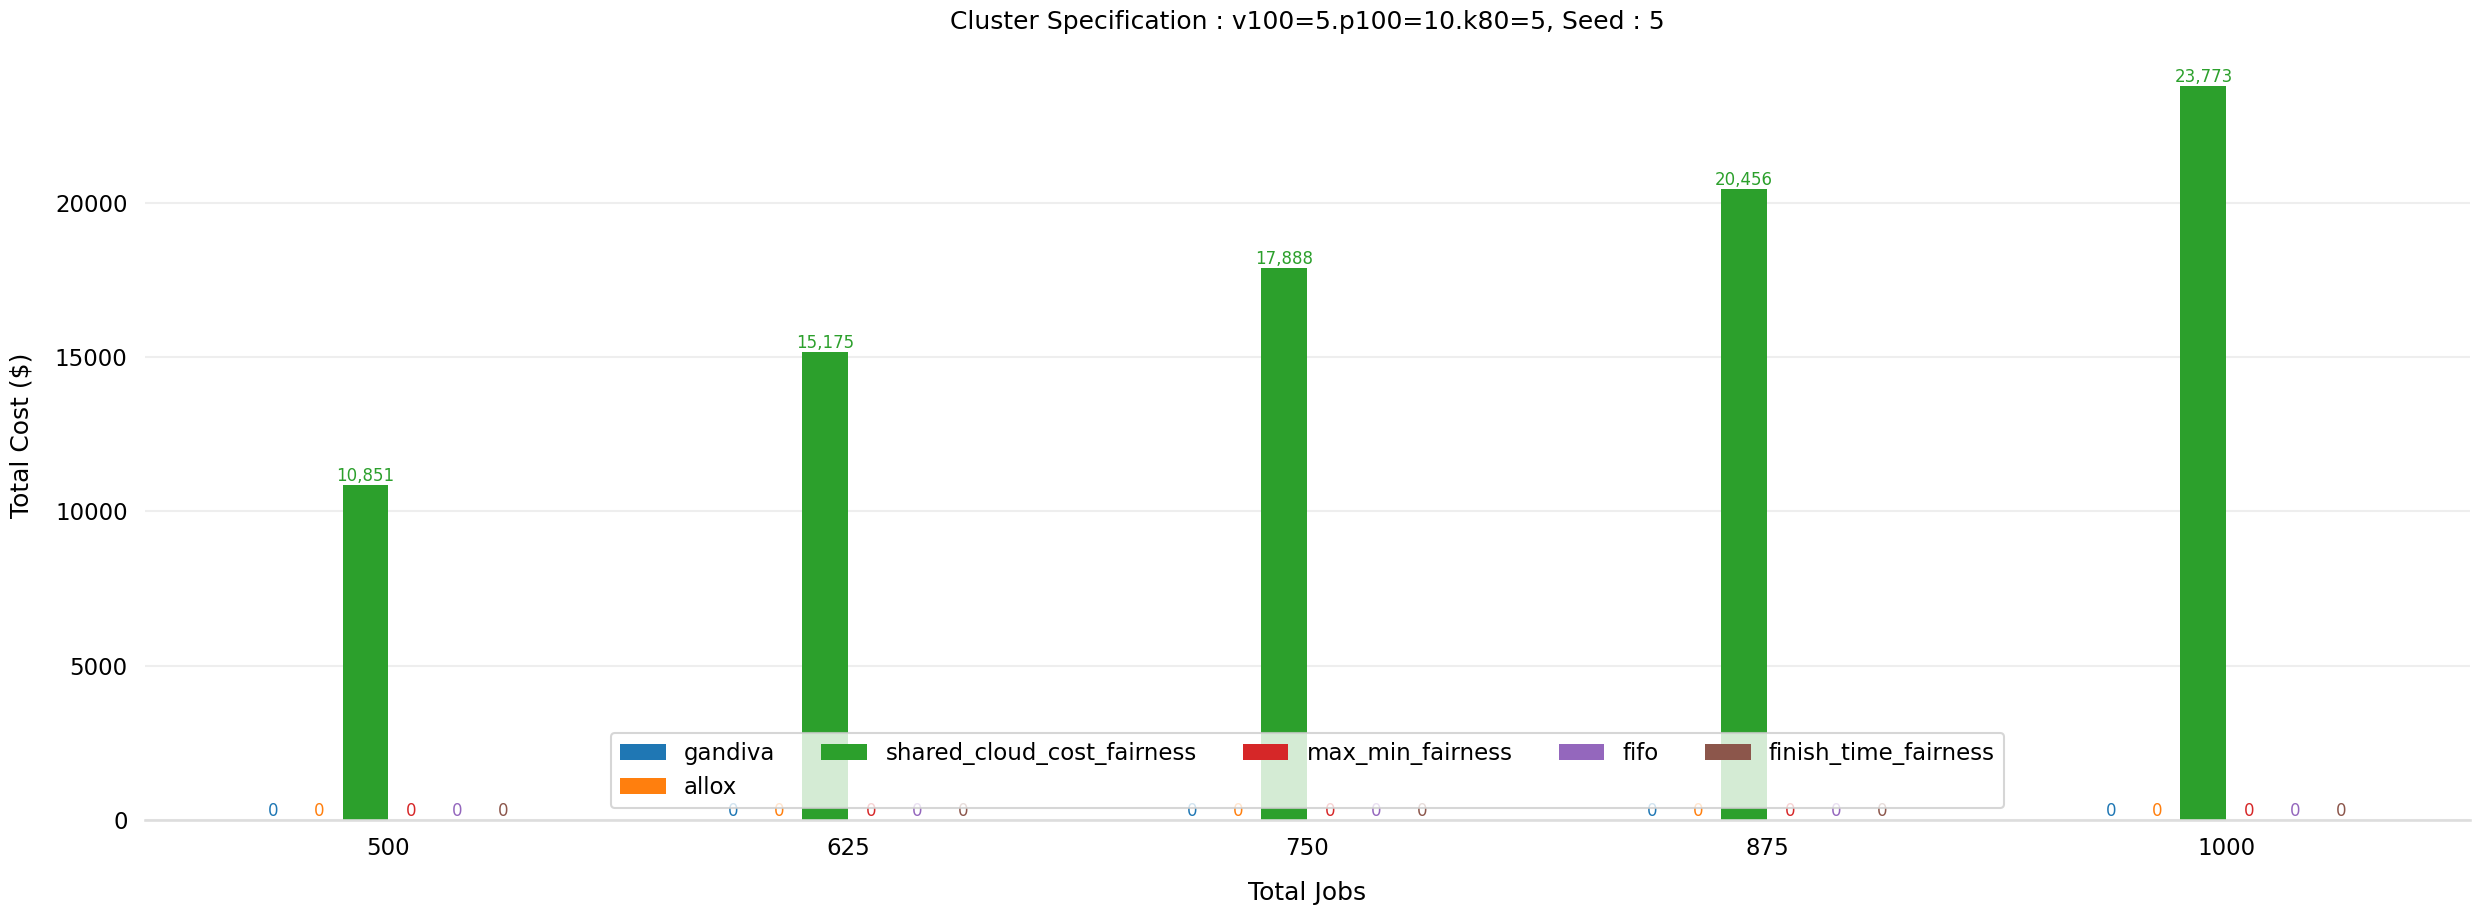

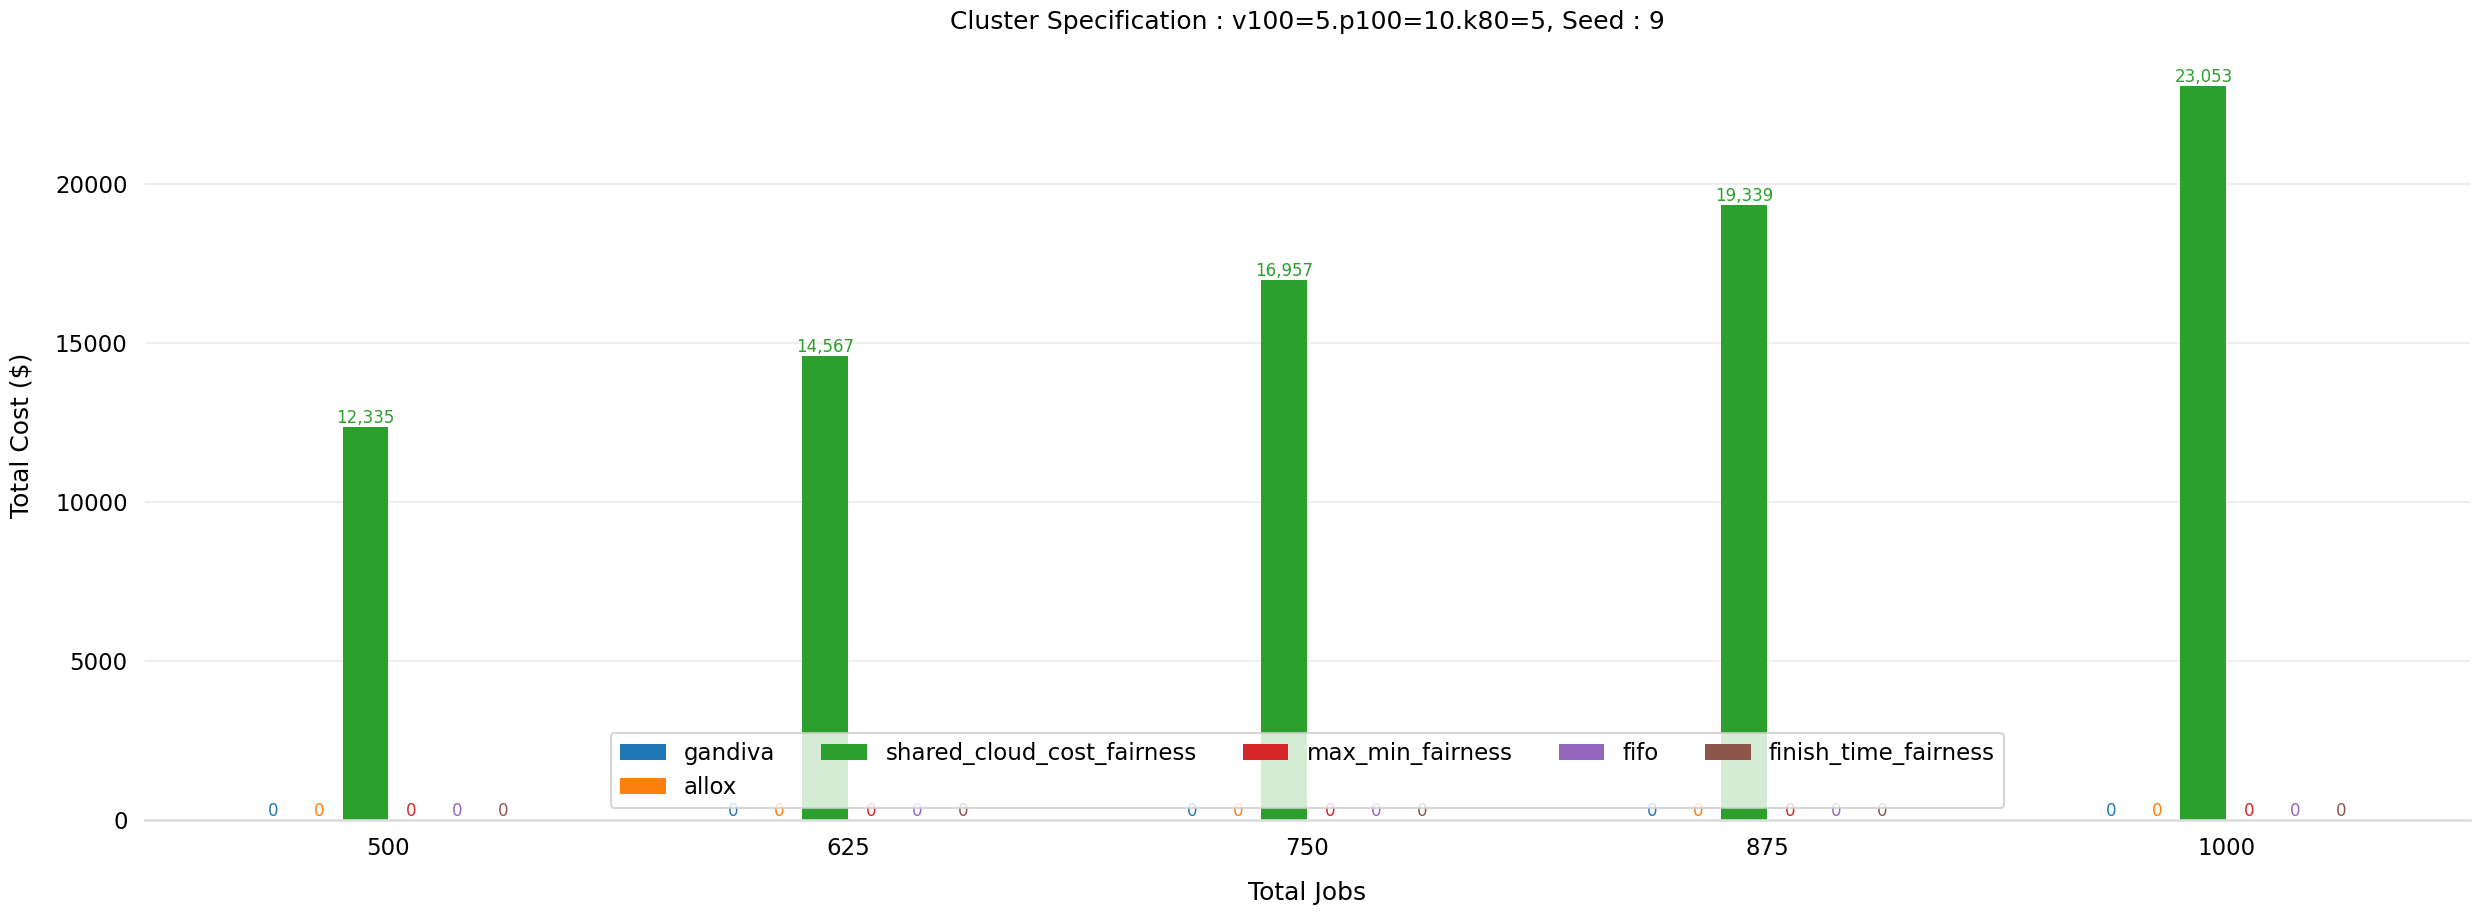

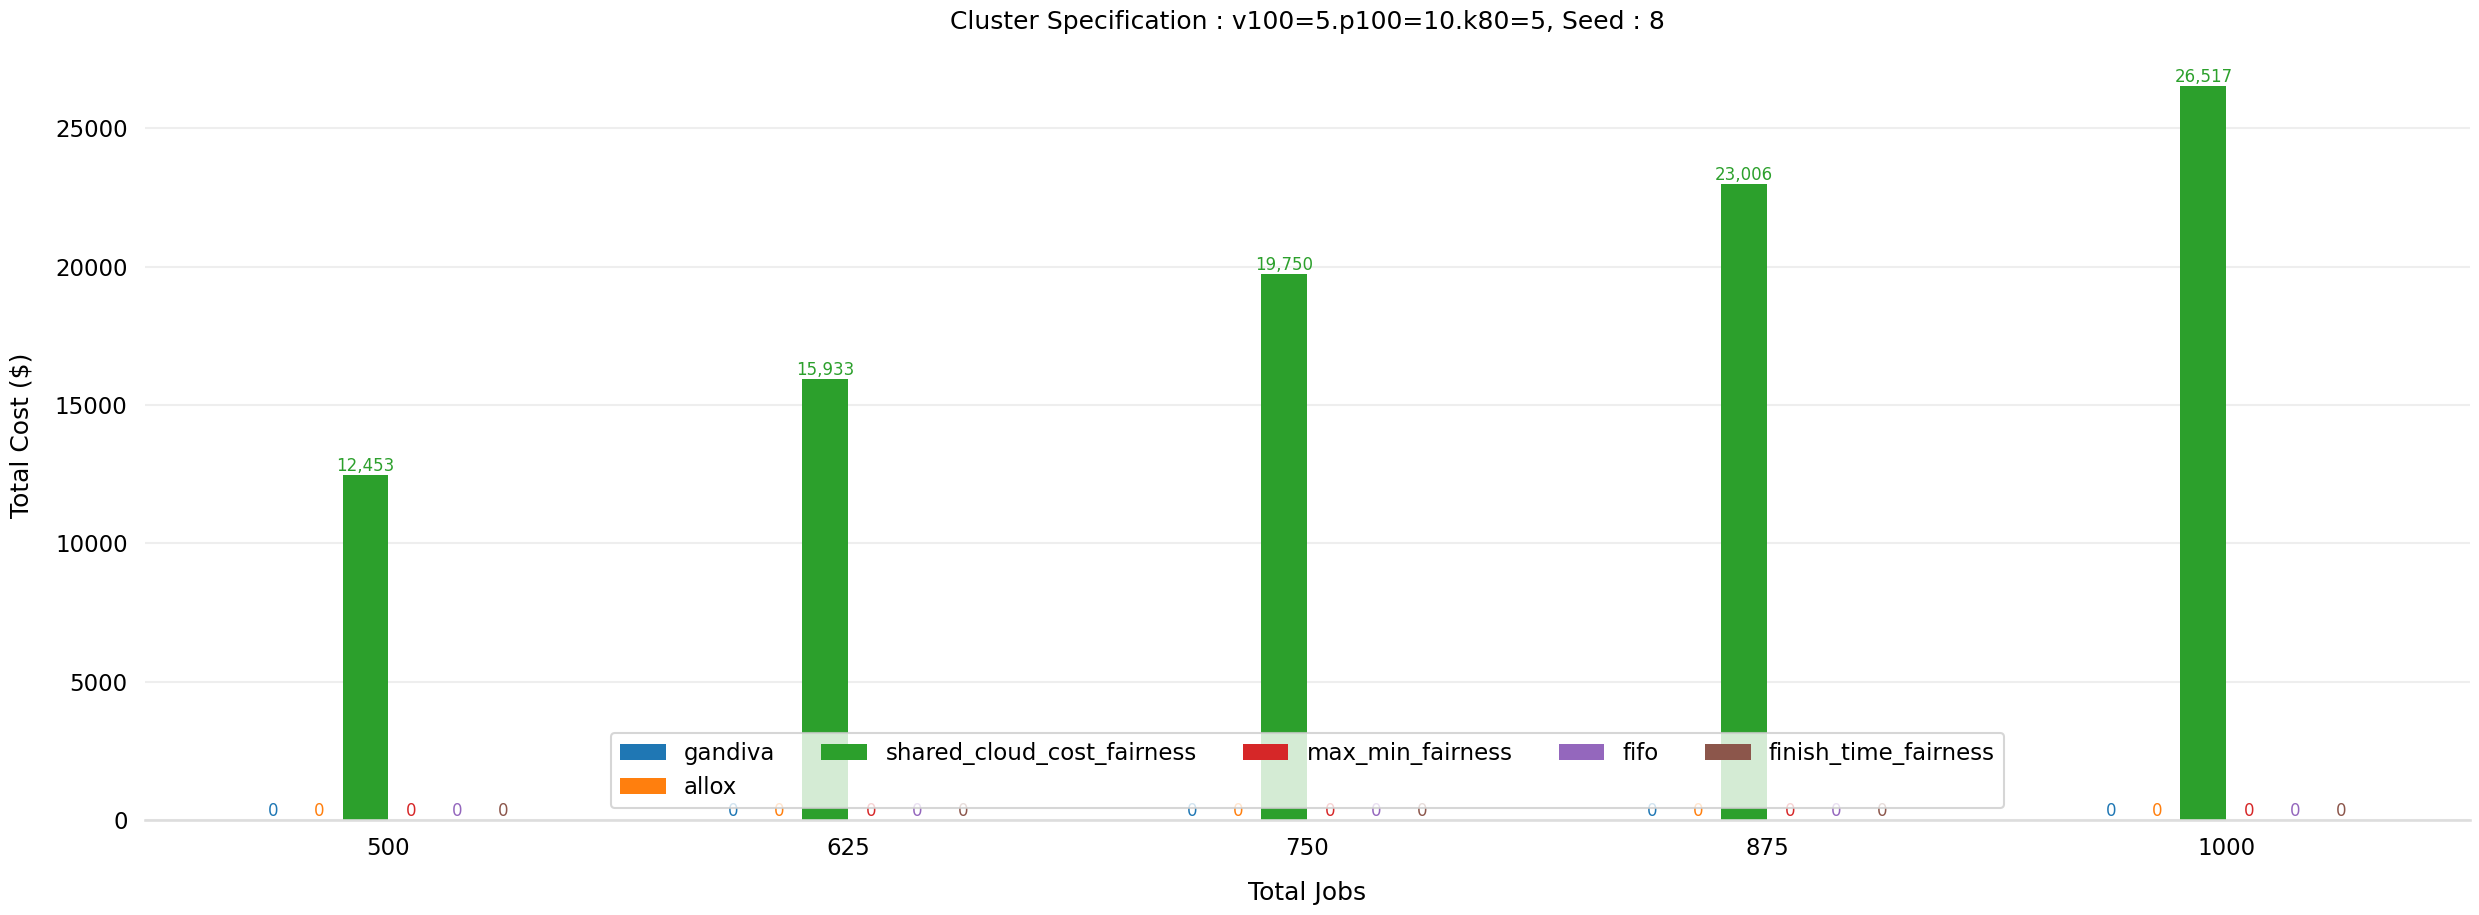

In [7]:
for cluster_spec in df_static["cluster_spec"].unique():
    for seed in df_static["seed"].unique():
        result_int = df_static.query(f'cluster_spec == "{cluster_spec}" & seed == {seed}')
        
        no_graphs = len(result_int["policy_name"].unique())

        fig, ax = plt.subplots(figsize=(30,10))
        bar_width = 0.1
        
        for idx, policy in enumerate(result_int["policy_name"].unique()):
            result = result_int.query(f'policy_name == "{policy}"')
            result = result.sort_values("total_jobs")

            x = np.arange(len(result["total_jobs"].unique()))
            y = [int(r) for r in result["cost"]]

            ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'{policy}')
            ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
            ax.set_xticklabels(result["total_jobs"].unique())

        ax.legend(loc ="lower center", ncols=5)

        ax.set_xlabel('Total Jobs', labelpad=15)
        ax.set_ylabel('Total Cost ($)', labelpad=15)
        ax.set_title(f'Cluster Specification : {cluster_spec}, Seed : {seed}', pad=15)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#DDDDDD')
        ax.tick_params(bottom=False, left=False)
        ax.set_axisbelow(True)
        
        ax.yaxis.grid(True, color='#EEEEEE')
        ax.xaxis.grid(False)

        # For each bar in the chart, add a text label.
        for bar in ax.patches:
        # The text annotation for each bar should be its height.
            bar_value = bar.get_height()
            # Format the text with commas to separate thousands. You can do
            # any type of formatting here though.
            text = f'{bar_value:,}'
            # This will give the middle of each bar on the x-axis.
            text_x = bar.get_x() + bar.get_width() / 2
            # get_y() is where the bar starts so we add the height to it.
            text_y = bar.get_y() + bar_value
            # If we want the text to be the same color as the bar, we can
            # get the color like so:
            bar_color = bar.get_facecolor()
            # If you want a consistent color, you can just set it as a constant, e.g. #222222
            ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                    size=12)
            